# TIME SERIES

## Tabla de contenido

## Objetivos

## Librerías necesarias

In [3]:
# que no se impriman info y warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tensorflow.keras import layers,callbacks,models,Sequential,losses
import seaborn as sns
from sklearn.metrics import confusion_matrix
#import keras_tuner
from tensorflow import keras
from keras import backend as K
import os,random
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers.experimental import preprocessing
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import csv
from datetime import datetime

## Helper fucntions

In [5]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ----------
  timesteps : array of timestep values
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (similar to start but for the end)
  label : label to show on plot about values, default None 
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

## Carga de datos

Descargamos los datos de https://www.coindesk.com/price/bitcoin/

In [6]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv 

--2023-12-11 16:29:34--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolviendo raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Conectando con raw.githubusercontent.com (raw.githubusercontent.com)[2606:50c0:8002::154]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 178509 (174K) [text/plain]
Guardando como: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’

BTC_USD_2013-10-01_ 100%[===================>] 174,33K  --.-KB/s    en 0,03s   

2023-12-11 16:29:35 (6,17 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’ guardado [178509/178509]



In [7]:
!ls

 10_time_series_forecasting_in_tensorflow.ipynb
 10_time_series_forecasting_with_tensorflow_video.ipynb
'Bitcoin price prediction.ipynb'
 BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
 BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1
 model_experiments


In [8]:
# importamos los datos con pandas

df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # prase the date column and tell pandas column 1 is a datetime 

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [10]:
len(df)

2787

We've collected the historical price of Bitcoin for the past ~8 years but there's 2787 samples.

Typically deep learning models usually like lots and lots and lots of samples (where lots and lots and lots can thousands to tens of thousands to millions).

A smaller number of samples is something you'll often run into with time series data problems.

> 🔑 **Note:** The **seasonality** of a time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seaonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.


-> afinar la definición

In [11]:
# Only want closing price for each day
# me quedo sólo con lo que preciso y hago un rename
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


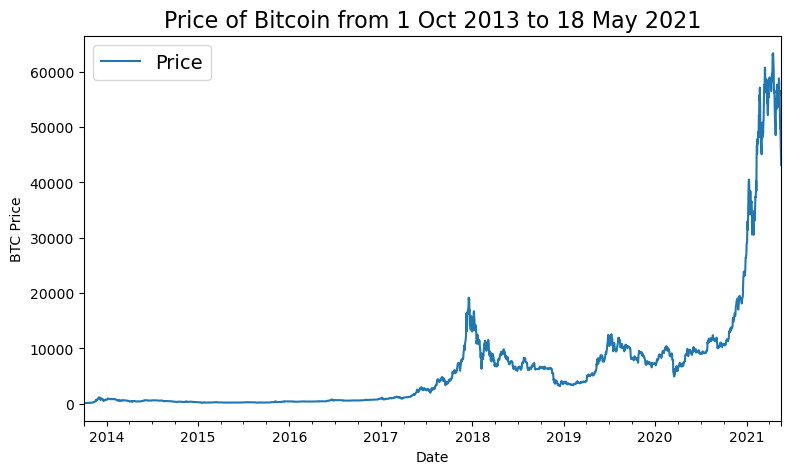

In [12]:
bitcoin_prices.plot(figsize=(9, 5))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

<b>Importando los datos usando el módulo CSV reader de python</b> (una alternativa a usar Pandas)

In [13]:
# Importing and formatting historical Bitcoin data with Python
timesteps = []
btc_price = []
with open("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings)
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

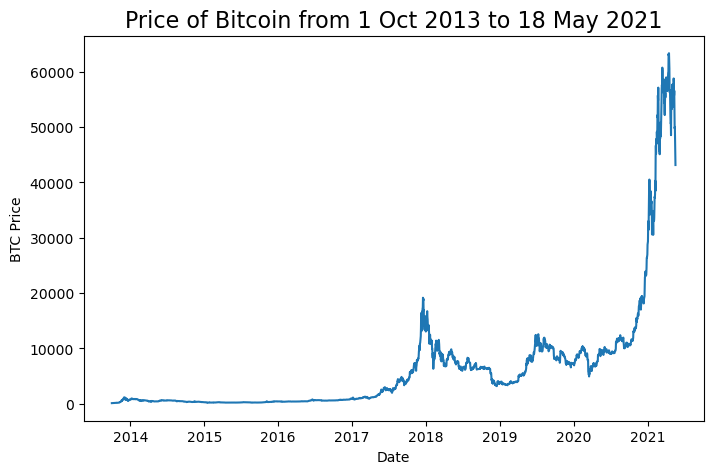

In [14]:
plt.figure(figsize=(8,5))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date");

### Train test split

NO puedo usar train_test_split de sklearn así nomás, pues hace una división aleatoria y esto es una serie temporal; el orden importa!!!

In [15]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [16]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test - you can change these values as needed, e.g. 90/10, 95/5

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

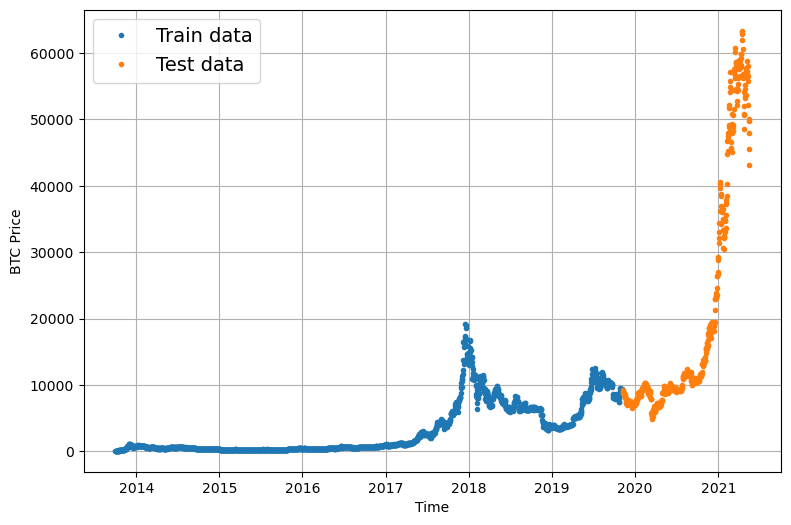

In [17]:
# Test out plotting function
plt.figure(figsize=(9, 6))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelos a probar

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with:
* **Horizon** = number of timesteps into the future we're going to predict
* **Window size** = number of timesteps we're going to use to predict **horizon**

Modelling experiments we're running:
* 0	Naïve model (baseline)	
* 1	Dense model, horizon = 1, window = 7
* 2	Same as 1, 	horizon = 1, window = 30
* 3	Same as 1, 	horizon = 7, window =	30
* 4	Conv1D
* 5	LSTM
* 6	Same as 1 (but with multivariate data)
* 7	N-BEATs Algorithm
* 8	Ensemble (multiple models optimized on different loss functions)
* 9	Future prediction model (model to predict future values)
* 10	Same as 1 (but with turkey 🦃 data introduced)

<b> <font color='green'>Naive Forecast</font></b>

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:

> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [18]:
# Create a naive forecast 
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

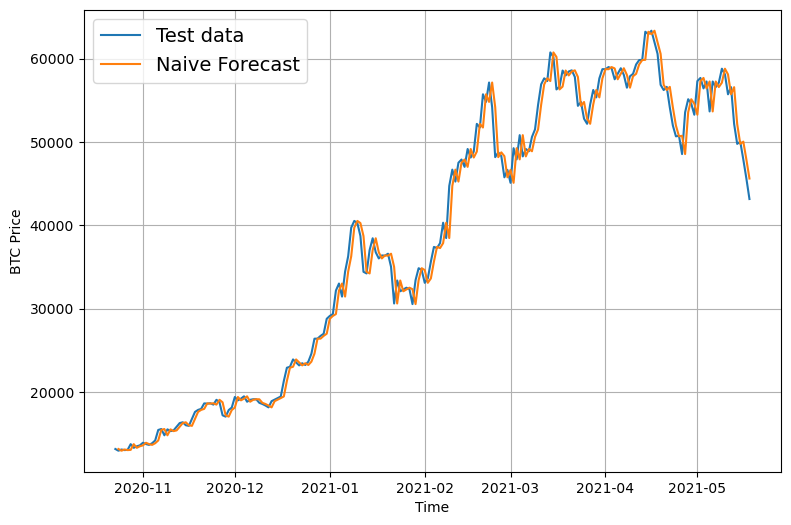

In [19]:
# Plot naive forecast
plt.figure(figsize=(9, 6))
# plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, start=350, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=350, format="-", label="Naive Forecast")

## Evaluando series temporales

Let's look into some evaluation metrics for time series forecasting. 

What are we doing?

We're predicting a number, so that means we have a form of a regression problem.

Because we're working on a regression problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean square error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error

For all of the above metrics, **lower is better**, for example, an MAE of 0 that is better than an MAE of 100.

The main thing we're evaluating here is: **how do our model's forecasts (y_pred) compare against the actual values (y_true or ground truth values)?**

> 📖 **Resource:** For a deeper dive on the various kinds of time series forecasting methods see [Forecasting: Principles and Practice chapter 5.8](https://otexts.com/fpp3/accuracy.html) 

<b> Implementando MASE </b>

In [20]:
# repaso reduce_mean

"""
tf.math.reduce_mean(
    input_tensor, axis=None, keepdims=False, name=None
)
"""

x = tf.constant( [ [1., 2.], [5.,3.] ])

print(x)

print(tf.math.reduce_mean(x)) # (1+2+5+3)/4  -> 2.75

print(tf.math.reduce_mean(x,axis=0)) # (1+5)/2 ; (2+3)/2

print(tf.math.reduce_mean(x,axis=1)) # (1+2)/2 ; (5+3)/2

print(tf.math.reduce_mean(x,axis=1,keepdims=True)) 

tf.Tensor(
[[1. 2.]
 [5. 3.]], shape=(2, 2), dtype=float32)
tf.Tensor(2.75, shape=(), dtype=float32)
tf.Tensor([3.  2.5], shape=(2,), dtype=float32)
tf.Tensor([1.5 4. ], shape=(2,), dtype=float32)
tf.Tensor(
[[1.5]
 [4. ]], shape=(2, 1), dtype=float32)


In [21]:
# ayuda para lo que sigue

y = np.array([1, 4, 7])


# yt - ty-1 : -> (7-4), (4-1)


print(y[1:]) # es desde la primera porque en la atrasada no tengo con qué restar al inicio
print(y[:-1])

y[1:] - y[:-1]



[4 7]
[1 4]


array([3, 3])

In [22]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)

  return mae / mae_naive_no_season

In [23]:
# Test MASE (this value should = 1 or be very close to 1 with the naive forecast)
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182624

Función para computar las distintas métricas

In [24]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics 
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [25]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)

naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

## <font color='#9400D3'> Format Data Part 2: Windowing our dataset </font>


--> antes usamos train/dev/test, ahora usaremos ventanas


Why do we window?

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [26]:
# What we want to do with our Bitcoin data
print(f"We want to use: {btc_price[:7]} to predict this: {btc_price[7]}")

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [27]:
# Let's setup global variables for window and horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of Bitcoin data to make the prediction

In [28]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [29]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


We've got a way to label our windowed data.

However, this only works on a small scale.

We need a way to do the above across our entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite lsow.

To speed things up, we'll leverage NumPy's array indexing - https://numpy.org/doc/stable/reference/arrays.indexing.html.

Our function will:
1. Create a window step of specific window size (e.g. [0, 1, 2, 3, 4, 5, 6])
2. Use NumPy indexing to create a 2D array of multiple window steps, for example: 
```
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7, 8]]
```
3. Uses the 2D array of multiple window steps (from 2.) to index on a target series (e.g. the historical price of Bitcoin)
4. Uses our `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon 

> 📖 **Resource:** The function we're about to create has been adapted from the following article: https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

In [30]:
# Ayuda de código


window_size = 3
horizon = 1


aux = np.array([10, 11, 12, 13, 14])


print(f"aux {aux}\n")


window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)


print(f"window step: {window_step}\n")

window_indexes = window_step + np.expand_dims(np.arange(len(aux)-(window_size+horizon-1)), axis=0).T 


print(f"window indexes {window_indexes}")


aux[window_indexes]




#aux[[[0,1,2,3],[1,2,3,4]]]


aux [10 11 12 13 14]

window step: [[0 1 2 3]]

window indexes [[0 1 2 3]
 [1 2 3 4]]


array([[10, 11, 12, 13],
       [11, 12, 13, 14]])

In [31]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    """
    Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
    """
    #print(f"entrada: {x}\n")


    # 1. Create a window of specific window_size (add the horzion on the end for labelling later)
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)


    print(f"window setp: {window_step}\n")


    # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T 
        # create 2D array of windows of size window_size
        # print(f"Window indexes:\n {window_indexes, window_indexes.shape}")

    # np.arange(4) -> [0,1,2,3]
    """
    np.expand_dims(np.arange(4),axis=0).T + [[1]]
    array([[1],
           [2],
           [3],
           [4]])
    """
        
        
        
    #print(f"window_indexes: {window_indexes}\n")


    # 3. Index on the target array (a time series) with 2D array of multiple window steps
    windowed_array = x[window_indexes]


    #print(f"windowed_array: {windowed_array}\n")


    # 4. Get the labelled windows
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return windows, labels

In [32]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

window setp: [[0 1 2 3 4 5 6 7]]



(2780, 2780)

In [33]:
# View the first 3 windows/labels
for i in range(3):
    print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


> 🔑 **Note:** There's a function which does similar to the above in tf.keras.preprocessing, an extension could be to try and replicate what we've done using the premade function: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array 

In [34]:
"""
tf.keras.utils.timeseries_dataset_from_array(
    data,
    targets,
    sequence_length,
    sequence_stride=1,
    sampling_rate=1,
    batch_size=128,
    shuffle=False,
    seed=None,
    start_index=None,
    end_index=None
)
"""


"""

La exploraré primero sólo con las entradas y leugo tmb. con los targets

"""




window_size = 3
horizon = 1
data = np.array([10, 11, 12, 13, 14])


aux = tf.keras.utils.timeseries_dataset_from_array(
    data,
    targets=None,
    sequence_length=window_size,
    sequence_stride=horizon
)


for a in aux:
    print(a)




tf.Tensor(
[[10 11 12]
 [11 12 13]
 [12 13 14]], shape=(3, 3), dtype=int64)


In [35]:
aux = tf.keras.utils.timeseries_dataset_from_array(
    prices,
    targets=None,
    sequence_length=WINDOW_SIZE,
    sequence_stride=HORIZON
)

for a in aux:
    print(a)
    

tf.Tensor(
[[ 123.65499  125.455    108.58483  118.67466  121.33866  120.65533
   121.795  ]
 [ 125.455    108.58483  118.67466  121.33866  120.65533  121.795
   123.033  ]
 [ 108.58483  118.67466  121.33866  120.65533  121.795    123.033
   124.049  ]
 [ 118.67466  121.33866  120.65533  121.795    123.033    124.049
   125.96116]
 [ 121.33866  120.65533  121.795    123.033    124.049    125.96116
   125.27966]
 [ 120.65533  121.795    123.033    124.049    125.96116  125.27966
   125.9275 ]
 [ 121.795    123.033    124.049    125.96116  125.27966  125.9275
   126.38333]
 [ 123.033    124.049    125.96116  125.27966  125.9275   126.38333
   135.24199]
 [ 124.049    125.96116  125.27966  125.9275   126.38333  135.24199
   133.20333]
 [ 125.96116  125.27966  125.9275   126.38333  135.24199  133.20333
   142.76333]
 [ 125.27966  125.9275   126.38333  135.24199  133.20333  142.76333
   137.92333]
 [ 125.9275   126.38333  135.24199  133.20333  142.76333  137.92333
   142.95166]
 [ 126.38333

tf.Tensor(
[[416.034   414.167   417.138   417.154   407.473   409.24    407.496  ]
 [414.167   417.138   417.154   407.473   409.24    407.496   415.125  ]
 [417.138   417.154   407.473   409.24    407.496   415.125   417.318  ]
 [417.154   407.473   409.24    407.496   415.125   417.318   415.837  ]
 [407.473   409.24    407.496   415.125   417.318   415.837   414.75699]
 [409.24    407.496   415.125   417.318   415.837   414.75699 416.851  ]
 [407.496   415.125   417.318   415.837   414.75699 416.851   416.233  ]
 [415.125   417.318   415.837   414.75699 416.851   416.233   424.297  ]
 [417.318   415.837   414.75699 416.851   416.233   424.297   423.597  ]
 [415.837   414.75699 416.851   416.233   424.297   423.597   414.613  ]
 [414.75699 416.851   416.233   424.297   423.597   414.613   414.458  ]
 [416.851   416.233   424.297   423.597   414.613   414.458   416.012  ]
 [416.233   424.297   423.597   414.613   414.458   416.012   418.785  ]
 [424.297   423.597   414.613   414.458 

tf.Tensor(
[[662.034   666.747   654.725   654.895   660.284   655.418   650.82899]
 [666.747   654.725   654.895   660.284   655.418   650.82899 656.91599]
 [654.725   654.895   660.284   655.418   650.82899 656.91599 655.427  ]
 [654.895   660.284   655.418   650.82899 656.91599 655.427   656.681  ]
 [660.284   655.418   650.82899 656.91599 655.427   656.681   635.588  ]
 [655.418   650.82899 656.91599 655.427   656.681   635.588   621.37299]
 [650.82899 656.91599 655.427   656.681   635.588   621.37299 601.227  ]
 [656.91599 655.427   656.681   635.588   621.37299 601.227   555.926  ]
 [655.427   656.681   635.588   621.37299 601.227   555.926   578.52374]
 [656.681   635.588   621.37299 601.227   555.926   578.52374 570.33875]
 [635.588   621.37299 601.227   555.926   578.52374 570.33875 574.87375]
 [621.37299 601.227   555.926   578.52374 570.33875 574.87375 588.51625]
 [601.227   555.926   578.52374 570.33875 574.87375 588.51625 589.66125]
 [555.926   578.52374 570.33875 574.8737

In [36]:
data = np.arange(1, 18)

# Definir la ventana de entrada (tamaño 3)
sequence_length = 3

# Crear el conjunto de datos usando timeseries_dataset_from_array
dataset = tf.keras.utils.timeseries_dataset_from_array(
    data,
    targets=data[sequence_length:],  # Puedes ajustar esto según tus necesidades específicas
    sequence_length=sequence_length,
    sequence_stride=1,
    batch_size=32  # Ajusta el tamaño del lote según tus necesidades
)

# Imprimir las muestras generadas
for batch in dataset:
    inputs, targets = batch
    print("Entradas:", inputs.numpy(), "Siguiente valor:", targets.numpy())


    
print(type(dataset))    


Entradas: [[ 1  2  3]
 [ 2  3  4]
 [ 3  4  5]
 [ 4  5  6]
 [ 5  6  7]
 [ 6  7  8]
 [ 7  8  9]
 [ 8  9 10]
 [ 9 10 11]
 [10 11 12]
 [11 12 13]
 [12 13 14]
 [13 14 15]
 [14 15 16]] Siguiente valor: [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17]
<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


## Turning windows into training and test sets

In [37]:
full_windows[:5], full_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [38]:
# Make the train/test splits para nuestro dataset ventaneado
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of winodws and labels into train and test splits.
    """
    split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test: len(windows)=2780 aqu[i
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [39]:
# Create train and test windows 
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [40]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [41]:
test_windows[:5], test_labels[:5]

(array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
         9335.75240233, 9226.48582088, 8794.35864452],
        [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
         9226.48582088, 8794.35864452, 8798.04205463],
        [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
         8794.35864452, 8798.04205463, 9081.18687849],
        [9326.59962378, 9335.75240233, 9226.48582088, 8794.35864452,
         8798.04205463, 9081.18687849, 8711.53433917],
        [9335.75240233, 9226.48582088, 8794.35864452, 8798.04205463,
         9081.18687849, 8711.53433917, 8760.89271814]]),
 array([[8798.04205463],
        [9081.18687849],
        [8711.53433917],
        [8760.89271814],
        [8749.52059102]]))

In [42]:
train_labels.shape, y_train.shape

((2224, 1), (2229,))

Como los arreglos anteriores tienen distinto shape, debemos hacer el squeeze para compararlos apropiadamente (hay que deshacerse de la dimension con tamanio 1)

In [43]:
# Check to see if train labels are the same (before and after window split)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint callback

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to compare each of our model's best performances against the other model's best performances.

For example if our model performs the best on epoch 55 (but we're training for 100 epochs), we want to load and evaluate the model saved on epoch 55.

We can create a modelling checkpoint callback using the following: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [44]:
# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor="val_loss",
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True)

## MODELOS

Probaremos distintos modelos.

### Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimizaiton and MAE loss function
* Batch size of 128 (previously we've used 32) 
* 100 epochs 

Why these values?

I picked them out of experimentation.

* **Hyperparameters** = values a machine learning practitioner (you!) can adjust themselves
* **Parameters** = values a model learns on its own

In [50]:
# 1. Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear")               
], name="model_1_dense") # name our model so we can save it

# 2. Compile
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# 3. Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
12/18 [===================>..........] - ETA: 0s - loss: 2092.7891 - mae: 2092.7891 - mse: 12127795.0000  

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 20s 614ms/step - loss: 1565.6630 - mae: 1565.6630 - mse: 8551988.0000 - val_loss: 2868.6318 - val_mae: 2868.6318 - val_mse: 17376240.0000
Epoch 2/100
15/18 [========================>.....] - ETA: 0s - loss: 363.7988 - mae: 363.7988 - mse: 476102.7812

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 8s 474ms/step - loss: 350.3177 - mae: 350.3177 - mse: 438750.5312 - val_loss: 1294.9534 - val_mae: 1294.9532 - val_mse: 4094741.7500
Epoch 3/100
13/18 [====================>.........] - ETA: 0s - loss: 181.0281 - mae: 181.0281 - mse: 157511.5156

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 8s 478ms/step - loss: 173.2682 - mae: 173.2682 - mse: 145073.4219 - val_loss: 855.8322 - val_mae: 855.8322 - val_mse: 2197617.7500
Epoch 4/100
15/18 [========================>.....] - ETA: 0s - loss: 145.2320 - mae: 145.2320 - mse: 115146.3281

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 8s 479ms/step - loss: 147.6045 - mae: 147.6045 - mse: 121148.8906 - val_loss: 797.5656 - val_mae: 797.5656 - val_mse: 2081228.0000
Epoch 5/100
18/18 [==============================] - 7s 399ms/step - loss: 143.1299 - mae: 143.1299 - mse: 112549.5469 - val_loss: 822.7496 - val_mae: 822.7496 - val_mse: 2046857.2500
Epoch 6/100
12/18 [===================>..........] - ETA: 0s - loss: 142.5253 - mae: 142.5253 - mse: 119111.8359

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 8s 467ms/step - loss: 140.6158 - mae: 140.6158 - mse: 110231.7344 - val_loss: 763.1176 - val_mae: 763.1176 - val_mse: 1897893.7500
Epoch 7/100
13/18 [====================>.........] - ETA: 0s - loss: 144.3669 - mae: 144.3669 - mse: 119336.1328

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 8s 485ms/step - loss: 135.5747 - mae: 135.5747 - mse: 103776.8594 - val_loss: 756.5637 - val_mae: 756.5637 - val_mse: 1830527.3750
Epoch 8/100
18/18 [==============================] - 7s 390ms/step - loss: 134.5956 - mae: 134.5956 - mse: 101142.5000 - val_loss: 770.5492 - val_mae: 770.5492 - val_mse: 1823632.8750
Epoch 9/100
 1/18 [>.............................] - ETA: 0s - loss: 106.6263 - mae: 106.6263 - mse: 50960.0508

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 7s 433ms/step - loss: 131.9263 - mae: 131.9263 - mse: 98906.8438 - val_loss: 725.9913 - val_mae: 725.9913 - val_mse: 1724245.0000
Epoch 10/100
18/18 [==============================] - 7s 409ms/step - loss: 132.6297 - mae: 132.6297 - mse: 97774.3672 - val_loss: 794.3015 - val_mae: 794.3015 - val_mse: 1850795.3750
Epoch 11/100
18/18 [==============================] - 7s 393ms/step - loss: 129.9384 - mae: 129.9384 - mse: 95381.4062 - val_loss: 767.9622 - val_mae: 767.9622 - val_mse: 1761266.6250
Epoch 12/100
14/18 [======================>.......] - ETA: 0s - loss: 126.8171 - mae: 126.8171 - mse: 94291.6094

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 4s 229ms/step - loss: 126.6941 - mae: 126.6941 - mse: 92140.9453 - val_loss: 717.9283 - val_mae: 717.9283 - val_mse: 1621103.6250
Epoch 13/100
16/18 [=========================>....] - ETA: 0s - loss: 126.5160 - mae: 126.5160 - mse: 93665.5938

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 4s 234ms/step - loss: 125.4139 - mae: 125.4139 - mse: 90672.6094 - val_loss: 707.1702 - val_mae: 707.1702 - val_mse: 1580115.1250
Epoch 14/100
13/18 [====================>.........] - ETA: 0s - loss: 126.0142 - mae: 126.0142 - mse: 86465.3438

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 4s 239ms/step - loss: 125.7588 - mae: 125.7588 - mse: 89189.6797 - val_loss: 678.8139 - val_mae: 678.8139 - val_mse: 1507055.2500
Epoch 15/100
18/18 [==============================] - 3s 162ms/step - loss: 122.3331 - mae: 122.3331 - mse: 86996.3125 - val_loss: 700.6558 - val_mae: 700.6558 - val_mse: 1542583.8750
Epoch 16/100
18/18 [==============================] - 3s 150ms/step - loss: 123.9429 - mae: 123.9429 - mse: 89843.4062 - val_loss: 699.3520 - val_mae: 699.3520 - val_mse: 1530881.3750
Epoch 17/100
14/18 [======================>.......] - ETA: 0s - loss: 122.9023 - mae: 122.9023 - mse: 82183.2969

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 4s 224ms/step - loss: 122.9985 - mae: 122.9985 - mse: 85674.4062 - val_loss: 665.0091 - val_mae: 665.0091 - val_mse: 1479953.7500
Epoch 18/100
18/18 [==============================] - 3s 170ms/step - loss: 124.5413 - mae: 124.5413 - mse: 85262.4375 - val_loss: 686.0311 - val_mae: 686.0311 - val_mse: 1553612.0000
Epoch 19/100
15/18 [========================>.....] - ETA: 0s - loss: 123.3616 - mae: 123.3616 - mse: 91385.0781

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 4s 221ms/step - loss: 121.7427 - mae: 121.7427 - mse: 86681.2891 - val_loss: 653.2174 - val_mae: 653.2174 - val_mse: 1405453.2500
Epoch 20/100
18/18 [==============================] - ETA: 0s - loss: 118.4090 - mae: 118.4090 - mse: 82765.2344

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 4s 243ms/step - loss: 118.4090 - mae: 118.4090 - mse: 82765.2344 - val_loss: 646.6528 - val_mae: 646.6528 - val_mse: 1408957.6250
Epoch 21/100
11/18 [=================>............] - ETA: 0s - loss: 122.1658 - mae: 122.1658 - mse: 90705.3516

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 4s 263ms/step - loss: 118.2693 - mae: 118.2693 - mse: 83621.9609 - val_loss: 632.5958 - val_mae: 632.5958 - val_mse: 1353164.3750
Epoch 22/100
13/18 [====================>.........] - ETA: 0s - loss: 119.1961 - mae: 119.1961 - mse: 86403.3203

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 4s 242ms/step - loss: 118.0688 - mae: 118.0688 - mse: 82994.3281 - val_loss: 629.0775 - val_mae: 629.0775 - val_mse: 1342705.3750
Epoch 23/100
18/18 [==============================] - 3s 163ms/step - loss: 116.9532 - mae: 116.9532 - mse: 81693.3438 - val_loss: 711.0159 - val_mae: 711.0159 - val_mse: 1531741.1250
Epoch 24/100
15/18 [========================>.....] - ETA: 0s - loss: 119.1056 - mae: 119.1056 - mse: 81649.3828

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 4s 225ms/step - loss: 119.7504 - mae: 119.7504 - mse: 81766.0938 - val_loss: 623.1592 - val_mae: 623.1592 - val_mse: 1324715.6250
Epoch 25/100
18/18 [==============================] - 3s 160ms/step - loss: 116.8460 - mae: 116.8460 - mse: 81617.0547 - val_loss: 647.9628 - val_mae: 647.9628 - val_mse: 1415764.6250
Epoch 26/100
18/18 [==============================] - 3s 149ms/step - loss: 116.6995 - mae: 116.6995 - mse: 80852.6328 - val_loss: 635.0495 - val_mae: 635.0495 - val_mse: 1340753.2500
Epoch 27/100
15/18 [========================>.....] - ETA: 0s - loss: 117.5781 - mae: 117.5781 - mse: 85134.3438

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 4s 234ms/step - loss: 117.4283 - mae: 117.4283 - mse: 81368.6875 - val_loss: 621.9890 - val_mae: 621.9890 - val_mse: 1310896.2500
Epoch 28/100
18/18 [==============================] - 3s 162ms/step - loss: 116.2603 - mae: 116.2603 - mse: 79444.0469 - val_loss: 629.0479 - val_mae: 629.0479 - val_mse: 1347574.2500
Epoch 29/100
15/18 [========================>.....] - ETA: 0s - loss: 112.8214 - mae: 112.8214 - mse: 77120.0078 

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 4s 216ms/step - loss: 113.3203 - mae: 113.3203 - mse: 78571.2969 - val_loss: 618.1346 - val_mae: 618.1346 - val_mse: 1307564.3750
Epoch 30/100
14/18 [======================>.......] - ETA: 0s - loss: 115.8604 - mae: 115.8604 - mse: 82578.6719 

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 4s 241ms/step - loss: 114.2611 - mae: 114.2611 - mse: 78308.9062 - val_loss: 611.5264 - val_mae: 611.5264 - val_mse: 1280922.2500
Epoch 31/100
13/18 [====================>.........] - ETA: 0s - loss: 106.1734 - mae: 106.1734 - mse: 62894.8516

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 4s 236ms/step - loss: 112.9091 - mae: 112.9091 - mse: 77433.3203 - val_loss: 606.6161 - val_mae: 606.6161 - val_mse: 1269441.8750
Epoch 32/100
18/18 [==============================] - 3s 155ms/step - loss: 112.0820 - mae: 112.0820 - mse: 76621.5938 - val_loss: 621.6833 - val_mae: 621.6833 - val_mse: 1320085.1250
Epoch 33/100
15/18 [========================>.....] - ETA: 0s - loss: 117.5357 - mae: 117.5357 - mse: 81301.4531

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 4s 229ms/step - loss: 115.9191 - mae: 115.9191 - mse: 76677.6094 - val_loss: 604.0845 - val_mae: 604.0845 - val_mse: 1259922.7500
Epoch 34/100
18/18 [==============================] - 3s 164ms/step - loss: 112.8798 - mae: 112.8798 - mse: 76102.5312 - val_loss: 616.4028 - val_mae: 616.4028 - val_mse: 1279475.6250
Epoch 35/100
18/18 [==============================] - 3s 151ms/step - loss: 117.5457 - mae: 117.5457 - mse: 77088.5938 - val_loss: 612.5381 - val_mae: 612.5381 - val_mse: 1288486.5000
Epoch 36/100
14/18 [======================>.......] - ETA: 0s - loss: 112.8023 - mae: 112.8023 - mse: 71746.9844

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 4s 223ms/step - loss: 115.1115 - mae: 115.1115 - mse: 76885.4297 - val_loss: 598.9272 - val_mae: 598.9272 - val_mse: 1244351.2500
Epoch 37/100
18/18 [==============================] - 3s 157ms/step - loss: 112.8819 - mae: 112.8819 - mse: 75372.5000 - val_loss: 601.0388 - val_mae: 601.0388 - val_mse: 1250404.1250
Epoch 38/100
18/18 [==============================] - 3s 152ms/step - loss: 110.8843 - mae: 110.8843 - mse: 74922.1484 - val_loss: 633.3006 - val_mae: 633.3006 - val_mse: 1309203.2500
Epoch 39/100
18/18 [==============================] - 3s 151ms/step - loss: 126.1552 - mae: 126.1552 - mse: 78466.5156 - val_loss: 654.2411 - val_mae: 654.2411 - val_mse: 1409978.5000
Epoch 40/100
18/18 [==============================] - 3s 157ms/step - loss: 119.4129 - mae: 119.4129 - mse: 78514.4922 - val_loss: 722.1755 - val_mae: 722.1755 - val_mse: 1608080.6250
Epoch 41/100
14/18 [======================>.......] - ETA: 0s - loss: 120.5141 - mae: 120.514

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 4s 225ms/step - loss: 123.2788 - mae: 123.2788 - mse: 83793.8047 - val_loss: 597.2546 - val_mae: 597.2546 - val_mse: 1241147.1250
Epoch 42/100
18/18 [==============================] - 3s 161ms/step - loss: 111.0656 - mae: 111.0656 - mse: 74658.1797 - val_loss: 613.8504 - val_mae: 613.8504 - val_mse: 1267575.0000
Epoch 43/100
18/18 [==============================] - 3s 157ms/step - loss: 110.6027 - mae: 110.6027 - mse: 74204.2500 - val_loss: 669.7993 - val_mae: 669.7993 - val_mse: 1389729.3750
Epoch 44/100
18/18 [==============================] - 3s 151ms/step - loss: 117.0561 - mae: 117.0561 - mse: 77675.7188 - val_loss: 626.2496 - val_mae: 626.2496 - val_mse: 1322212.7500
Epoch 45/100
14/18 [======================>.......] - ETA: 0s - loss: 115.6461 - mae: 115.6461 - mse: 75132.7344

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 4s 224ms/step - loss: 114.0648 - mae: 114.0648 - mse: 75637.2578 - val_loss: 590.5810 - val_mae: 590.5810 - val_mse: 1218937.5000
Epoch 46/100
18/18 [==============================] - 3s 162ms/step - loss: 116.4264 - mae: 116.4264 - mse: 78172.1328 - val_loss: 839.7062 - val_mae: 839.7062 - val_mse: 1985886.6250
Epoch 47/100
18/18 [==============================] - 3s 151ms/step - loss: 122.6693 - mae: 122.6693 - mse: 82340.7500 - val_loss: 595.2831 - val_mae: 595.2831 - val_mse: 1226699.2500
Epoch 48/100
18/18 [==============================] - 3s 153ms/step - loss: 110.9388 - mae: 110.9388 - mse: 74978.2891 - val_loss: 597.9928 - val_mae: 597.9928 - val_mse: 1245236.0000
Epoch 49/100
18/18 [==============================] - 3s 150ms/step - loss: 111.5490 - mae: 111.5490 - mse: 73099.6641 - val_loss: 666.5469 - val_mae: 666.5469 - val_mse: 1381352.7500
Epoch 50/100
16/18 [=========================>....] - ETA: 0s - loss: 116.1884 - mae: 116.188

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 4s 222ms/step - loss: 113.2350 - mae: 113.2350 - mse: 74622.3516 - val_loss: 590.1390 - val_mae: 590.1390 - val_mse: 1220637.8750
Epoch 51/100
18/18 [==============================] - 3s 161ms/step - loss: 110.5273 - mae: 110.5273 - mse: 72934.6328 - val_loss: 667.3062 - val_mae: 667.3062 - val_mse: 1436474.7500
Epoch 52/100
15/18 [========================>.....] - ETA: 0s - loss: 114.5743 - mae: 114.5743 - mse: 78517.4766

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 4s 227ms/step - loss: 114.1542 - mae: 114.1542 - mse: 75694.9375 - val_loss: 584.8660 - val_mae: 584.8660 - val_mse: 1208312.6250
Epoch 53/100
18/18 [==============================] - 3s 159ms/step - loss: 111.0221 - mae: 111.0221 - mse: 72824.5938 - val_loss: 640.9602 - val_mae: 640.9602 - val_mse: 1359729.5000
Epoch 54/100
18/18 [==============================] - 3s 152ms/step - loss: 117.3799 - mae: 117.3799 - mse: 75857.9219 - val_loss: 622.8309 - val_mae: 622.8309 - val_mse: 1277992.0000
Epoch 55/100
18/18 [==============================] - 3s 147ms/step - loss: 113.1345 - mae: 113.1345 - mse: 75580.7891 - val_loss: 612.5164 - val_mae: 612.5164 - val_mse: 1279588.3750
Epoch 56/100
14/18 [======================>.......] - ETA: 0s - loss: 112.6095 - mae: 112.6095 - mse: 75435.1953

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 4s 238ms/step - loss: 110.1584 - mae: 110.1584 - mse: 71971.4453 - val_loss: 583.4382 - val_mae: 583.4382 - val_mse: 1199405.0000
Epoch 57/100
18/18 [==============================] - 3s 161ms/step - loss: 114.1799 - mae: 114.1799 - mse: 74394.3750 - val_loss: 587.2573 - val_mae: 587.2573 - val_mse: 1215801.7500
Epoch 58/100
15/18 [========================>.....] - ETA: 0s - loss: 111.8961 - mae: 111.8961 - mse: 73301.5000

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 4s 226ms/step - loss: 111.3157 - mae: 111.3157 - mse: 74524.9375 - val_loss: 583.1870 - val_mae: 583.1870 - val_mse: 1195689.5000
Epoch 59/100
18/18 [==============================] - 3s 163ms/step - loss: 107.8622 - mae: 107.8622 - mse: 70773.3516 - val_loss: 583.4982 - val_mae: 583.4982 - val_mse: 1205591.0000
Epoch 60/100
18/18 [==============================] - 3s 151ms/step - loss: 109.8666 - mae: 109.8666 - mse: 72692.4141 - val_loss: 635.9451 - val_mae: 635.9451 - val_mse: 1298906.7500
Epoch 61/100
18/18 [==============================] - 3s 151ms/step - loss: 110.3842 - mae: 110.3842 - mse: 72129.8594 - val_loss: 585.4757 - val_mae: 585.4757 - val_mse: 1196340.2500
Epoch 62/100
18/18 [==============================] - 3s 150ms/step - loss: 108.5457 - mae: 108.5457 - mse: 71445.5469 - val_loss: 602.9730 - val_mae: 602.9730 - val_mse: 1252554.1250
Epoch 63/100
18/18 [==============================] - 3s 153ms/step - loss: 109.9320 - mae: 1

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 4s 224ms/step - loss: 109.6454 - mae: 109.6454 - mse: 74102.7969 - val_loss: 577.3099 - val_mae: 577.3099 - val_mse: 1190153.3750
Epoch 68/100
18/18 [==============================] - 3s 156ms/step - loss: 107.4787 - mae: 107.4787 - mse: 71333.7031 - val_loss: 593.7999 - val_mae: 593.7999 - val_mse: 1207373.8750
Epoch 69/100
18/18 [==============================] - 3s 155ms/step - loss: 107.9201 - mae: 107.9201 - mse: 69398.7344 - val_loss: 578.8853 - val_mae: 578.8853 - val_mse: 1180522.2500
Epoch 70/100
18/18 [==============================] - 3s 158ms/step - loss: 113.9685 - mae: 113.9685 - mse: 72251.0938 - val_loss: 735.9075 - val_mae: 735.9075 - val_mse: 1619752.7500
Epoch 71/100
18/18 [==============================] - 3s 154ms/step - loss: 110.7382 - mae: 110.7382 - mse: 70861.7109 - val_loss: 578.0120 - val_mae: 578.0120 - val_mse: 1178382.0000
Epoch 72/100
14/18 [======================>.......] - ETA: 0s - loss: 105.1680 - mae: 105.168

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 4s 222ms/step - loss: 109.2722 - mae: 109.2722 - mse: 71065.5938 - val_loss: 575.8472 - val_mae: 575.8472 - val_mse: 1187293.0000
Epoch 73/100
18/18 [==============================] - 3s 160ms/step - loss: 115.2482 - mae: 115.2482 - mse: 71967.3047 - val_loss: 643.7083 - val_mae: 643.7083 - val_mse: 1318749.5000
Epoch 74/100
18/18 [==============================] - 3s 151ms/step - loss: 118.4595 - mae: 118.4595 - mse: 76004.5859 - val_loss: 624.9346 - val_mae: 624.9346 - val_mse: 1302868.2500
Epoch 75/100
18/18 [==============================] - 3s 153ms/step - loss: 107.1701 - mae: 107.1701 - mse: 68736.6406 - val_loss: 583.7456 - val_mae: 583.7456 - val_mse: 1208719.7500
Epoch 76/100
18/18 [==============================] - 3s 152ms/step - loss: 110.0600 - mae: 110.0600 - mse: 71796.1797 - val_loss: 608.3516 - val_mae: 608.3516 - val_mse: 1236644.8750
Epoch 77/100
18/18 [==============================] - 3s 153ms/step - loss: 109.4243 - mae: 1

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 4s 230ms/step - loss: 114.2528 - mae: 114.2528 - mse: 75679.2109 - val_loss: 569.3028 - val_mae: 569.3028 - val_mse: 1169221.5000
Epoch 83/100
18/18 [==============================] - 3s 166ms/step - loss: 107.3397 - mae: 107.3397 - mse: 69215.6328 - val_loss: 612.8638 - val_mae: 612.8638 - val_mse: 1274528.7500
Epoch 84/100
18/18 [==============================] - 3s 151ms/step - loss: 107.5238 - mae: 107.5238 - mse: 69419.9844 - val_loss: 626.3076 - val_mae: 626.3076 - val_mse: 1300256.7500
Epoch 85/100
18/18 [==============================] - 2s 146ms/step - loss: 112.4546 - mae: 112.4546 - mse: 71858.1250 - val_loss: 617.7500 - val_mae: 617.7500 - val_mse: 1252978.6250
Epoch 86/100
18/18 [==============================] - 3s 151ms/step - loss: 113.1513 - mae: 113.1513 - mse: 72952.0078 - val_loss: 591.9734 - val_mae: 591.9734 - val_mse: 1221407.3750
Epoch 87/100
18/18 [==============================] - 3s 154ms/step - loss: 109.0590 - mae: 1

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 4s 225ms/step - loss: 108.1246 - mae: 108.1246 - mse: 69683.9844 - val_loss: 568.6423 - val_mae: 568.6423 - val_mse: 1167961.3750
Epoch 89/100
18/18 [==============================] - 3s 154ms/step - loss: 106.7551 - mae: 106.7551 - mse: 69756.0078 - val_loss: 581.1609 - val_mae: 581.1609 - val_mse: 1184069.7500
Epoch 90/100
18/18 [==============================] - 3s 149ms/step - loss: 108.6320 - mae: 108.6320 - mse: 71147.7891 - val_loss: 615.6082 - val_mae: 615.6082 - val_mse: 1277664.8750
Epoch 91/100
18/18 [==============================] - 3s 149ms/step - loss: 107.7352 - mae: 107.7352 - mse: 69841.9844 - val_loss: 569.1108 - val_mae: 569.1108 - val_mse: 1161302.0000
Epoch 92/100
18/18 [==============================] - 3s 149ms/step - loss: 106.0667 - mae: 106.0667 - mse: 68595.3516 - val_loss: 573.5012 - val_mae: 573.5012 - val_mse: 1183497.5000
Epoch 93/100
14/18 [======================>.......] - ETA: 0s - loss: 108.5474 - mae: 108.547

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 4s 213ms/step - loss: 106.0891 - mae: 106.0891 - mse: 68774.2109 - val_loss: 568.3724 - val_mae: 568.3724 - val_mse: 1162602.3750
Epoch 94/100
18/18 [==============================] - 3s 161ms/step - loss: 108.3322 - mae: 108.3322 - mse: 68233.9141 - val_loss: 673.6637 - val_mae: 673.6637 - val_mse: 1383900.7500
Epoch 95/100
18/18 [==============================] - 2s 145ms/step - loss: 116.5190 - mae: 116.5190 - mse: 72737.0312 - val_loss: 641.5853 - val_mae: 641.5853 - val_mse: 1311091.5000
Epoch 96/100
18/18 [==============================] - 3s 148ms/step - loss: 107.8395 - mae: 107.8395 - mse: 70027.7734 - val_loss: 589.4084 - val_mae: 589.4084 - val_mse: 1195544.3750
Epoch 97/100
18/18 [==============================] - 3s 151ms/step - loss: 108.6287 - mae: 108.6287 - mse: 71172.3828 - val_loss: 578.3364 - val_mae: 578.3364 - val_mse: 1191600.3750
Epoch 98/100
13/18 [====================>.........] - ETA: 0s - loss: 106.3302 - mae: 106.330

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 4s 219ms/step - loss: 108.5293 - mae: 108.5293 - mse: 70564.8047 - val_loss: 567.7196 - val_mae: 567.7196 - val_mse: 1163274.8750
Epoch 99/100
18/18 [==============================] - 3s 158ms/step - loss: 106.0037 - mae: 106.0037 - mse: 67326.1016 - val_loss: 577.9264 - val_mae: 577.9264 - val_mse: 1174571.6250
Epoch 100/100
18/18 [==============================] - 3s 156ms/step - loss: 111.9670 - mae: 111.9670 - mse: 70068.2812 - val_loss: 605.3766 - val_mae: 605.3766 - val_mse: 1230429.0000


In [51]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 3s 4ms/step - loss: 605.3766 - mae: 605.3766 - mse: 1230428.7500


[605.3765869140625, 605.3765869140625, 1230428.75]

In [45]:
# Load in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 567.7196 - mae: 567.7196 - mse: 1163274.8750


[567.7196044921875, 567.7196044921875, 1163274.875]

### Making forecasts with a model (on the test dataset)

To make "forecasts" on the test dataset (note: these won't be actual forecasts, they're only psuedo forecasts because actual forecasts are into the future), let's write a function to:

1. Take in a train model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions 

In [46]:
def make_preds(model, input_data):
  """
  Uses model to make predictions input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [47]:
# Make predictions using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows) 
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 1ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8839.102, 8779.101, 8994.886, 8770.263, 8776.421, 8689.773,
        8685.369, 8510.457, 8450.48 , 8512.33 ], dtype=float32)>)

In [48]:
tf.squeeze(test_labels).shape, model_1_preds.shape

(TensorShape([556]), TensorShape([556]))

In [49]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 567.71954,
 'mse': 1163274.8,
 'rmse': 1078.5521,
 'mape': 2.557755,
 'mase': 0.997326}

In [50]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

In [51]:
test_labels.shape

(556, 1)

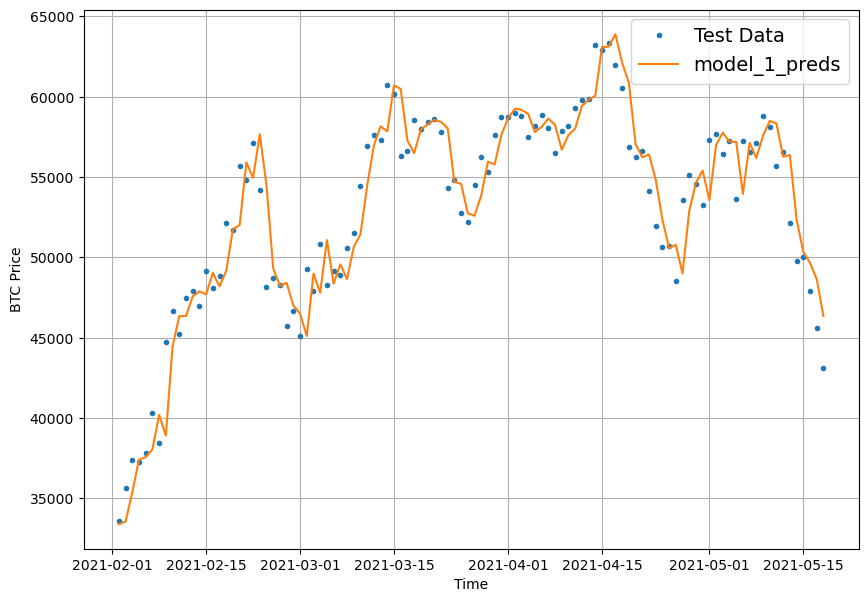

In [52]:
# Let's plot our model 1 predictions
offset = 450
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test Data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds,
                 start=offset, 
                 format="-",
                 label="model_1_preds")

### Model 2: Dense (window = 30, horizon = 1)

In [53]:
HORIZON = 1 # predict one step at a time (one day of Bitcoin prices)
WINDOW_SIZE = 30 # use 30 timesteps in past

In [54]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)


window setp: [[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30]]



(2757, 2757)

In [55]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [66]:

#import absl.logging
#absl.logging.set_verbosity(absl.logging.ERROR)



# Create model
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_2_dense")

# Compile
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


In [67]:
# Evaluate model 2 on test data
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 2s 3ms/step - loss: 711.5032


711.503173828125

In [56]:
# Load in the best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 638.0246


638.0245971679688

In [57]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 [==============================] - 0s 1ms/step


In [58]:
tf.squeeze(test_labels).shape, model_2_preds.shape

(TensorShape([552]), TensorShape([552]))

In [59]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

{'mae': 638.0246,
 'mse': 1394639.2,
 'rmse': 1180.9485,
 'mape': 2.8341322,
 'mase': 1.1152731}

In [60]:
model_1_results

{'mae': 567.71954,
 'mse': 1163274.8,
 'rmse': 1078.5521,
 'mape': 2.557755,
 'mase': 0.997326}

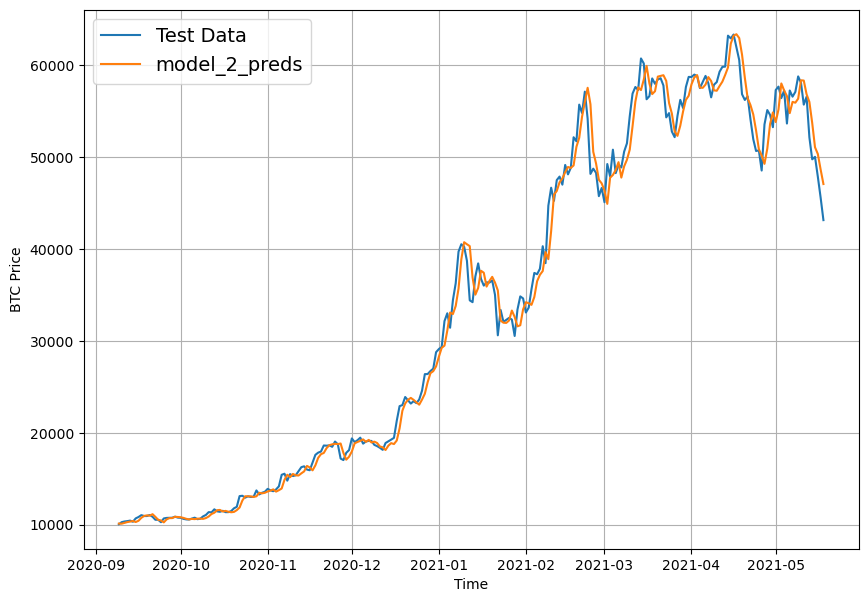

In [61]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, format="-", label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

### Model 3: Dense (window = 30, horizon = 7)

In [62]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [63]:
prices[:10]

array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  , 123.033  , 124.049  , 125.96116])

In [64]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

window setp: [[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31 32 33 34 35 36]]



(2751, 2751)

In [65]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [66]:
def build_model_arq1(horizon,name):
    model = tf.keras.Sequential([
      layers.Dense(128, activation="relu"),
      layers.Dense(horizon)
    ], name=name)
    return model
    

In [80]:
# build
model_3 = build_model_arq1(HORIZON,"model_3_dense")

# Compile
model_3.compile(loss="MAE",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

Epoch 1/100
12/18 [===================>..........] - ETA: 0s - loss: 2639.1091  INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 19s 570ms/step - loss: 2270.1941 - val_loss: 5791.6606
Epoch 2/100
14/18 [======================>.......] - ETA: 0s - loss: 650.1761 INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 8s 464ms/step - loss: 633.5262 - val_loss: 2532.1270
Epoch 3/100
15/18 [========================>.....] - ETA: 0s - loss: 442.7328INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 4s 226ms/step - loss: 432.7866 - val_loss: 2391.5435
Epoch 4/100
12/18 [===================>..........] - ETA: 0s - loss: 398.9554INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 4s 237ms/step - loss: 384.2367 - val_loss: 1942.3467
Epoch 5/100
18/18 [==============================] - 3s 167ms/step - loss: 361.0821 - val_loss: 1943.6615
Epoch 6/100
13/18 [====================>.........] - ETA: 0s - loss: 361.2849INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 4s 213ms/step - loss: 344.1886 - val_loss: 1768.8789
Epoch 7/100
14/18 [======================>.......] - ETA: 0s - loss: 323.9063INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 4s 226ms/step - loss: 330.1219 - val_loss: 1682.9568
Epoch 8/100
18/18 [==============================] - 3s 163ms/step - loss: 319.5902 - val_loss: 1709.1088
Epoch 9/100
15/18 [========================>.....] - ETA: 0s - loss: 311.8464INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 4s 214ms/step - loss: 308.9303 - val_loss: 1650.4434
Epoch 10/100
18/18 [==============================] - 3s 158ms/step - loss: 305.8604 - val_loss: 1699.1807
Epoch 11/100
14/18 [======================>.......] - ETA: 0s - loss: 302.9837INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 4s 226ms/step - loss: 301.5754 - val_loss: 1642.7747
Epoch 12/100
16/18 [=========================>....] - ETA: 0s - loss: 287.2351INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 4s 228ms/step - loss: 286.6664 - val_loss: 1556.1661
Epoch 13/100
13/18 [====================>.........] - ETA: 0s - loss: 272.4953INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 4s 224ms/step - loss: 278.0891 - val_loss: 1477.1538
Epoch 14/100
18/18 [==============================] - 3s 159ms/step - loss: 276.8574 - val_loss: 1540.4271
Epoch 15/100
18/18 [==============================] - 3s 151ms/step - loss: 271.9645 - val_loss: 1614.3217
Epoch 16/100
18/18 [==============================] - 3s 155ms/step - loss: 275.9416 - val_loss: 1759.5846
Epoch 17/100
18/18 [==============================] - 3s 151ms/step - loss: 271.0386 - val_loss: 1654.8058
Epoch 18/100
13/18 [====================>.........] - ETA: 0s - loss: 270.8666INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 4s 220ms/step - loss: 269.6369 - val_loss: 1461.4957
Epoch 19/100
16/18 [=========================>....] - ETA: 0s - loss: 268.8062INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 4s 224ms/step - loss: 271.1724 - val_loss: 1437.0299
Epoch 20/100
13/18 [====================>.........] - ETA: 0s - loss: 276.5213INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 4s 220ms/step - loss: 262.3022 - val_loss: 1390.7211
Epoch 21/100
18/18 [==============================] - 3s 160ms/step - loss: 256.6707 - val_loss: 1463.5098
Epoch 22/100
18/18 [==============================] - 3s 149ms/step - loss: 251.2312 - val_loss: 1391.7533
Epoch 23/100
18/18 [==============================] - 3s 149ms/step - loss: 253.2961 - val_loss: 1480.0007
Epoch 24/100
13/18 [====================>.........] - ETA: 0s - loss: 252.3694INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 4s 223ms/step - loss: 248.2249 - val_loss: 1376.9574
Epoch 25/100
18/18 [==============================] - 3s 170ms/step - loss: 246.8361 - val_loss: 1657.7025
Epoch 26/100
18/18 [==============================] - 3s 147ms/step - loss: 252.6801 - val_loss: 1615.3535
Epoch 27/100
14/18 [======================>.......] - ETA: 0s - loss: 253.9896INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 4s 213ms/step - loss: 249.7136 - val_loss: 1371.4240
Epoch 28/100
18/18 [==============================] - 3s 161ms/step - loss: 243.4238 - val_loss: 1460.9047
Epoch 29/100
18/18 [==============================] - 3s 164ms/step - loss: 250.1641 - val_loss: 1389.4111
Epoch 30/100
15/18 [========================>.....] - ETA: 0s - loss: 257.2940INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 4s 213ms/step - loss: 257.5331 - val_loss: 1339.4673
Epoch 31/100
18/18 [==============================] - 2s 140ms/step - loss: 241.6330 - val_loss: 1371.7235
Epoch 32/100
13/18 [====================>.........] - ETA: 0s - loss: 245.2882INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 4s 222ms/step - loss: 239.1550 - val_loss: 1316.6100
Epoch 33/100
18/18 [==============================] - 3s 173ms/step - loss: 240.6933 - val_loss: 1412.0529
Epoch 34/100
14/18 [======================>.......] - ETA: 0s - loss: 242.5137INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 4s 213ms/step - loss: 246.5285 - val_loss: 1308.0386
Epoch 35/100
18/18 [==============================] - 3s 177ms/step - loss: 240.5161 - val_loss: 1312.0603
Epoch 36/100
18/18 [==============================] - 3s 166ms/step - loss: 246.5619 - val_loss: 1324.0791
Epoch 37/100
18/18 [==============================] - 3s 163ms/step - loss: 242.5628 - val_loss: 1405.8691
Epoch 38/100
18/18 [==============================] - 3s 164ms/step - loss: 240.9673 - val_loss: 1499.6926
Epoch 39/100
18/18 [==============================] - 3s 162ms/step - loss: 245.4082 - val_loss: 1311.7567
Epoch 40/100
18/18 [==============================] - 3s 165ms/step - loss: 235.5133 - val_loss: 1339.0613
Epoch 41/100
16/18 [=========================>....] - ETA: 0s - loss: 243.2406INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 4s 229ms/step - loss: 242.1608 - val_loss: 1299.8630
Epoch 42/100
18/18 [==============================] - 3s 178ms/step - loss: 242.5050 - val_loss: 1301.1292
Epoch 43/100
18/18 [==============================] - 3s 167ms/step - loss: 243.0531 - val_loss: 1367.0730
Epoch 44/100
18/18 [==============================] - 3s 163ms/step - loss: 240.5387 - val_loss: 1353.7477
Epoch 45/100
17/18 [===========================>..] - ETA: 0s - loss: 235.8747INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 4s 227ms/step - loss: 234.2492 - val_loss: 1285.8055
Epoch 46/100
18/18 [==============================] - 3s 176ms/step - loss: 236.0773 - val_loss: 1444.8436
Epoch 47/100
18/18 [==============================] - 3s 163ms/step - loss: 237.0062 - val_loss: 1315.5272
Epoch 48/100
17/18 [===========================>..] - ETA: 0s - loss: 232.8850INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 4s 228ms/step - loss: 234.5241 - val_loss: 1285.2368
Epoch 49/100
18/18 [==============================] - 3s 180ms/step - loss: 235.8454 - val_loss: 1318.1200
Epoch 50/100
18/18 [==============================] - 3s 164ms/step - loss: 234.5080 - val_loss: 1363.3787
Epoch 51/100
18/18 [==============================] - 3s 163ms/step - loss: 234.4081 - val_loss: 1380.9061
Epoch 52/100
18/18 [==============================] - 3s 161ms/step - loss: 234.9353 - val_loss: 1352.0947
Epoch 53/100
18/18 [==============================] - 3s 172ms/step - loss: 234.2019 - val_loss: 1340.2434
Epoch 54/100
18/18 [==============================] - 3s 168ms/step - loss: 240.2628 - val_loss: 1383.1608
Epoch 55/100
13/18 [====================>.........] - ETA: 0s - loss: 254.3271INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 4s 230ms/step - loss: 251.2493 - val_loss: 1281.9716
Epoch 56/100
18/18 [==============================] - 3s 186ms/step - loss: 237.0264 - val_loss: 1642.2402
Epoch 57/100
18/18 [==============================] - 3s 165ms/step - loss: 251.8501 - val_loss: 1568.1799
Epoch 58/100
18/18 [==============================] - 3s 164ms/step - loss: 239.5258 - val_loss: 1323.1819
Epoch 59/100
18/18 [==============================] - 3s 164ms/step - loss: 231.2460 - val_loss: 1337.2157
Epoch 60/100
18/18 [==============================] - 3s 163ms/step - loss: 230.5275 - val_loss: 1492.3732
Epoch 61/100
16/18 [=========================>....] - ETA: 0s - loss: 235.6523INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 4s 222ms/step - loss: 232.2929 - val_loss: 1276.2917
Epoch 62/100
18/18 [==============================] - 3s 179ms/step - loss: 230.4764 - val_loss: 1511.4703
Epoch 63/100
18/18 [==============================] - 3s 165ms/step - loss: 232.1022 - val_loss: 1286.9779
Epoch 64/100
18/18 [==============================] - 3s 184ms/step - loss: 230.2014 - val_loss: 1323.8241
Epoch 65/100
18/18 [==============================] - 3s 167ms/step - loss: 230.0624 - val_loss: 1283.7422
Epoch 66/100
18/18 [==============================] - 3s 161ms/step - loss: 227.1662 - val_loss: 1390.6113
Epoch 67/100
18/18 [==============================] - 3s 162ms/step - loss: 230.6444 - val_loss: 1344.6973
Epoch 68/100
18/18 [==============================] - 3s 164ms/step - loss: 228.1143 - val_loss: 1324.4188
Epoch 69/100
18/18 [==============================] - 3s 165ms/step - loss: 231.6334 - val_loss: 1381.4253
Epoch 70/100
18/18 [==============================

INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 4s 224ms/step - loss: 230.2012 - val_loss: 1273.4814
Epoch 72/100
18/18 [==============================] - 3s 180ms/step - loss: 235.8833 - val_loss: 1318.2894
Epoch 73/100
18/18 [==============================] - 3s 165ms/step - loss: 228.7628 - val_loss: 1358.1588
Epoch 74/100
18/18 [==============================] - 3s 162ms/step - loss: 232.0607 - val_loss: 1292.2100
Epoch 75/100
18/18 [==============================] - 3s 168ms/step - loss: 227.7287 - val_loss: 1276.9741
Epoch 76/100
18/18 [==============================] - 3s 162ms/step - loss: 228.7307 - val_loss: 1286.4604
Epoch 77/100
18/18 [==============================] - 3s 164ms/step - loss: 231.3463 - val_loss: 1282.1538
Epoch 78/100
16/18 [=========================>....] - ETA: 0s - loss: 229.8646INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 4s 225ms/step - loss: 227.9284 - val_loss: 1260.8369
Epoch 79/100
18/18 [==============================] - 3s 180ms/step - loss: 225.8139 - val_loss: 1278.8623
Epoch 80/100
18/18 [==============================] - 3s 164ms/step - loss: 225.6283 - val_loss: 1269.0977
Epoch 81/100
18/18 [==============================] - 3s 164ms/step - loss: 226.4957 - val_loss: 1310.6738
Epoch 82/100
18/18 [==============================] - 3s 162ms/step - loss: 230.3148 - val_loss: 1313.9852
Epoch 83/100
18/18 [==============================] - 3s 173ms/step - loss: 238.1760 - val_loss: 1319.2812
Epoch 84/100
18/18 [==============================] - 3s 164ms/step - loss: 230.5950 - val_loss: 1269.3966
Epoch 85/100
14/18 [======================>.......] - ETA: 0s - loss: 225.0011INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 4s 234ms/step - loss: 225.7147 - val_loss: 1240.6742
Epoch 86/100
14/18 [======================>.......] - ETA: 0s - loss: 221.4898INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 4s 240ms/step - loss: 227.5133 - val_loss: 1232.6573
Epoch 87/100
18/18 [==============================] - 3s 179ms/step - loss: 232.2941 - val_loss: 1347.6274
Epoch 88/100
18/18 [==============================] - 3s 164ms/step - loss: 236.9503 - val_loss: 1391.2712
Epoch 89/100
18/18 [==============================] - 3s 166ms/step - loss: 227.1820 - val_loss: 1240.4125
Epoch 90/100
18/18 [==============================] - 3s 171ms/step - loss: 225.8540 - val_loss: 1312.8730
Epoch 91/100
18/18 [==============================] - 3s 162ms/step - loss: 227.5296 - val_loss: 1240.0490
Epoch 92/100
18/18 [==============================] - 3s 165ms/step - loss: 228.8429 - val_loss: 1291.4908
Epoch 93/100
17/18 [===========================>..] - ETA: 0s - loss: 223.2345INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


18/18 [==============================] - 4s 228ms/step - loss: 223.8485 - val_loss: 1229.4498
Epoch 94/100
18/18 [==============================] - 3s 183ms/step - loss: 228.6358 - val_loss: 1330.4991
Epoch 95/100
18/18 [==============================] - 3s 162ms/step - loss: 232.0547 - val_loss: 1442.4535
Epoch 96/100
18/18 [==============================] - 3s 165ms/step - loss: 226.6221 - val_loss: 1305.9816
Epoch 97/100
18/18 [==============================] - 3s 192ms/step - loss: 224.7748 - val_loss: 1277.7271
Epoch 98/100
18/18 [==============================] - 3s 160ms/step - loss: 221.7679 - val_loss: 1364.0068
Epoch 99/100
18/18 [==============================] - 3s 163ms/step - loss: 227.1757 - val_loss: 1300.3475
Epoch 100/100
18/18 [==============================] - 3s 163ms/step - loss: 224.0734 - val_loss: 1249.4102


In [82]:
# Evaluate the model on the test data

# va a ser mayor xq aotra el horizonte ya no es 1, sino que mucho m[as
# predceinos mucho m[as alla en el futuro]

model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 1s 1ms/step - loss: 1249.4102


1249.41015625

In [67]:
# Load best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 980us/step - loss: 1229.4498


1229.4498291015625

In [68]:
# Make predictions with model_3
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

18/18 [==============================] - 0s 831us/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9343.65 , 9332.62 , 9388.586, 9430.069, 9494.41 , 9481.167,
        9768.468],
       [9006.663, 9109.024, 8998.934, 9070.089, 9042.176, 9157.989,
        9260.968],
       [8739.268, 8870.123, 8884.828, 8928.307, 9019.678, 9099.829,
        9049.939],
       [8787.226, 8892.511, 9045.964, 9057.402, 9192.353, 9349.307,
        9130.95 ],
       [8662.47 , 8805.069, 9065.918, 8936.129, 9116.969, 9344.89 ,
        9099.368]], dtype=float32)>

In [69]:
model_2_results

{'mae': 638.0246,
 'mse': 1394639.2,
 'rmse': 1180.9485,
 'mape': 2.8341322,
 'mase': 1.1152731}

In [70]:
model_3_preds.shape, model_2_preds.shape, model_1_preds.shape

(TensorShape([551, 7]), TensorShape([552]), TensorShape([556]))

In [71]:
# Evaluate model_3 results (these are going multi-dimensional because we're trying to predict more than one timestep at a time)
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([ 669.4951  ,  341.00754 ,  335.1144  ,  438.5071  ,  478.1748  ,
         499.12827 ,  512.37695 ,  601.0909  ,  581.9723  ,  664.9132  ,
         838.3371  ,  750.3349  ,  769.3456  ,  753.1436  ,  618.5244  ,
         298.83844 ,  189.96414 ,  232.75963 ,  267.67935 ,  307.01645 ,
         195.00252 ,  229.77072 ,  341.05734 ,  392.19174 ,  203.79416 ,
         138.65291 ,  151.02162 ,  202.57303 ,  154.63547 ,  258.9135  ,
         352.75537 ,  408.2233  ,  336.44244 ,  422.95822 ,  299.68744 ,
         317.1472  ,  338.13156 ,  288.1651  ,  235.80545 ,  142.31613 ,
         401.8231  ,   49.648857,  133.5593  ,   90.96749 ,   87.421455,
         129.1898  ,  111.56306 ,  107.82994 ,  120.31557 ,  131.57492 ,
         179.53516 ,  179.02734 ,  203.13094 ,  126.9119  ,  186.97224 ,
         309.98822 ,  490.90317 ,  466.55936 ,  445.69217 ,  511.24643 ,
         382.33273 ,  149.80789 ,  236.9052  ,  348.18576 ,  335.79605 ,
         452.9523  ,  478.3227  ,  599.2575 

In [72]:
model_3_preds.shape # el 7 es xq el horizonte es 7

TensorShape([551, 7])

### Make our evaluation function work for larger horizons

In [73]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 1229.4498


1229.4498291015625

In [74]:
tf.reduce_mean(model_3_results["mae"]).numpy()

1229.4498

In [75]:
model_2_results["mae"].ndim

0

In [76]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics 
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [77]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1229.4498,
 'mse': 5336977.0,
 'rmse': 1412.3282,
 'mape': 5.5942445,
 'mase': 2.1877372}

In [78]:
model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9343.65 , 9332.62 , 9388.586, 9430.069, 9494.41 , 9481.167,
        9768.468],
       [9006.663, 9109.024, 8998.934, 9070.089, 9042.176, 9157.989,
        9260.968],
       [8739.268, 8870.123, 8884.828, 8928.307, 9019.678, 9099.829,
        9049.939],
       [8787.226, 8892.511, 9045.964, 9057.402, 9192.353, 9349.307,
        9130.95 ],
       [8662.47 , 8805.069, 9065.918, 8936.129, 9116.969, 9344.89 ,
        9099.368]], dtype=float32)>

In [79]:
test_labels[:]

array([[ 8794.35864452,  8798.04205463,  9081.18687849, ...,
         8760.89271814,  8749.52059102,  8656.97092235],
       [ 8798.04205463,  9081.18687849,  8711.53433917, ...,
         8749.52059102,  8656.97092235,  8500.64355816],
       [ 9081.18687849,  8711.53433917,  8760.89271814, ...,
         8656.97092235,  8500.64355816,  8469.2608989 ],
       ...,
       [58102.19142623, 55715.54665129, 56573.5554719 , ...,
        49764.1320816 , 50032.69313676, 47885.62525472],
       [55715.54665129, 56573.5554719 , 52147.82118698, ...,
        50032.69313676, 47885.62525472, 45604.61575361],
       [56573.5554719 , 52147.82118698, 49764.1320816 , ...,
        47885.62525472, 45604.61575361, 43144.47129086]])

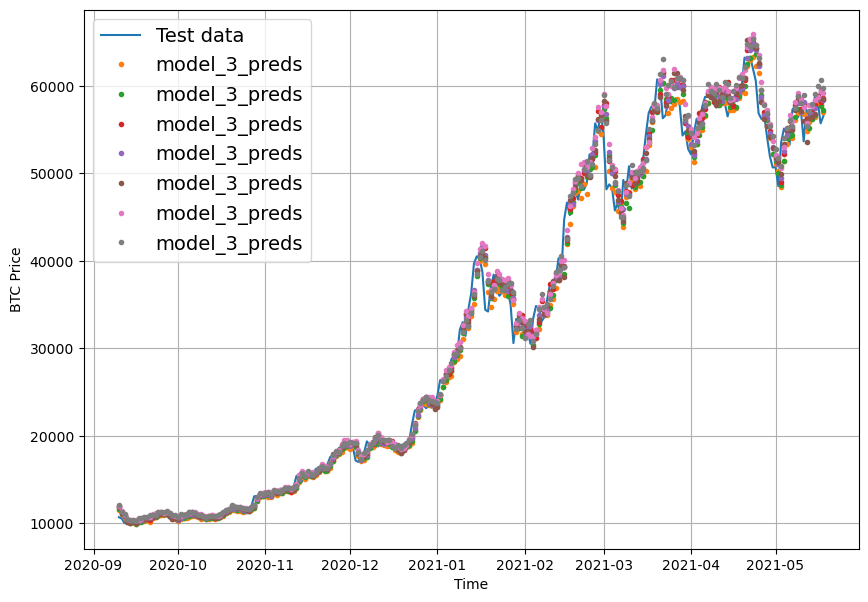

In [80]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, format="-", label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

In [81]:
model_3_preds[0]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([9343.65 , 9332.62 , 9388.586, 9430.069, 9494.41 , 9481.167,
       9768.468], dtype=float32)>

In [82]:
tf.reduce_mean(model_3_preds[0])

<tf.Tensor: shape=(), dtype=float32, numpy=9462.71>

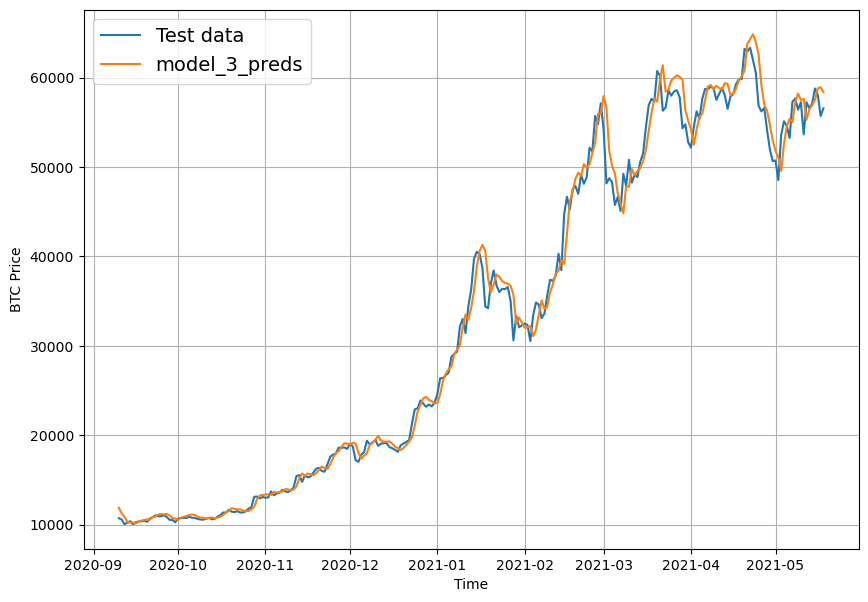

In [86]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 format="-",
                 label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(model_3_preds, axis=1), 
                 start=offset,
                 format="-", 
                 label="model_3_preds")

## Which of our models is performing the best so far? 

So we've trained a few models, now let's compare them and see how they've gone... 

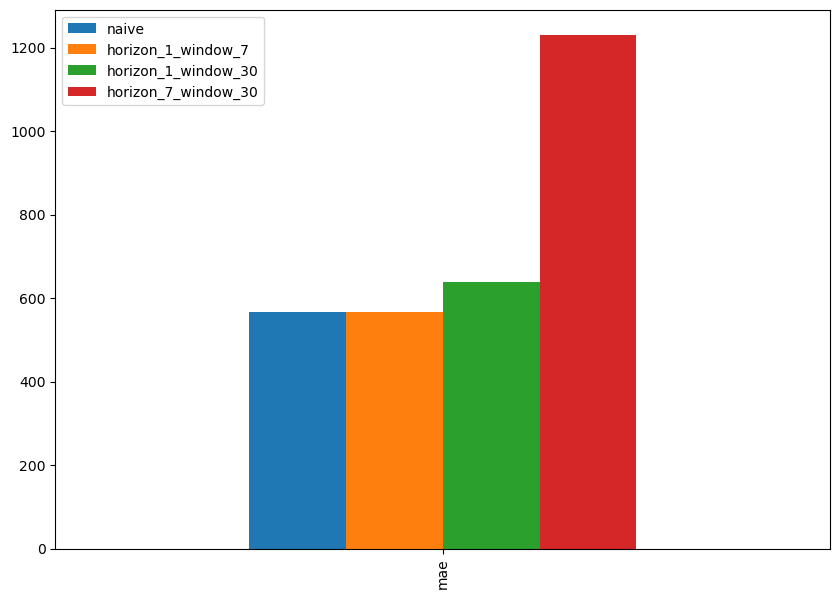

In [87]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

recuerdo que mientras menor sea el error, mejor

> 🔑 **Note:** You might be wondering, why are the naïve results so good? One of the reasons could be due the presence of autocorrelation in the data. If a time series has autocorrelation it means the value at `t+1` (the next timestep) is typically close to the value at `t` (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of course, this isn't always the case but when it is (stock market prices often seem autocorrelated but often fluctuate randomly), a naïve model will often get fairly good results.

> 📖 **Resource:** For more on how autocorrelation influences a model's predictions, see the article [How (not) to use Machine Learning for time series forecasting: Avoiding the pitfalls by Vegard Flovik](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424).

### Model 4: Conv1D

In [90]:
HORIZON = 1 # predict next day of Bitcoin prices
WINDOW_SIZE = 7 # use previous week worth data

In [91]:
# Create windowed data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

window setp: [[0 1 2 3 4 5 6 7]]



(2780, 2780)

In [92]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2224, 2224, 556, 556)

To use the Conv1D layer, we need an input shape of: `(batch_size, timesteps, input_dim)`...

However our data isn't in that shape yet...

En el contexto de un problema de series temporales con un horizonte (horizon) de 1 y un tamaño de ventana (window_size) de 7, la forma del tensor de entrada (input_shape) sería crucial para determinar el tamaño de input_dim. La forma general del tensor sería (batch_size, window_size, input_dim).

Dado que window_size es 7, el modelo consideraría secuencias de 7 pasos temporales como entrada en cada lote. Sin embargo, el horizonte de predicción (horizon) es 1, lo que significa que el modelo está diseñado para predecir el siguiente paso temporal en cada secuencia.

Por lo tanto, el tamaño de input_dim debe ser el número de características o variables en cada paso temporal. Si tus secuencias tienen una única característica en cada paso de tiempo (por ejemplo, univariadas), entonces input_dim sería 1. Si tienes múltiples características en cada paso de tiempo (por ejemplo, series temporales multivariadas), entonces input_dim sería el número total de características.

Entonces, en resumen, para un problema de series temporales con un horizonte de 1 y una ventana de 7, y si tus datos tienen una sola característica en cada paso de tiempo, input_dim debería ser 1. Si tienes múltiples características en cada paso de tiempo, input_dim sería el número total de características.

In [94]:
# Check data input shape
train_windows[0].shape # returns (WINDOW_SIZE, )



(7,)

In [95]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [96]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for `input_dim`


# queremos que el modelo prediga un día con una 1 semana de datos, por eso input_dim=1?????


In [97]:
# Test out our lambda layer
print(f"Original shape: {x.shape}") # (WINDIW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # output = ...?
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [103]:

#https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D

# nota expand dims

aux = tf.constant([1,2,3])

print(aux.shape)


aux2 = tf.expand_dims(aux,axis=1)


print(aux2.shape)


print(aux2)


(3,)
(3, 1)
tf.Tensor(
[[1]
 [2]
 [3]], shape=(3, 1), dtype=int32)


In [109]:
def build_model_4(x,horizon):
    model = tf.keras.Sequential([
        layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
        tf.keras.layers.Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="relu"),
        tf.keras.layers.Dense(horizon)
    ],name="model_4_conv1D")
    return model
    
    
model_4 = build_model_4(x,1)
    

In [110]:
# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_4.fit(train_windows,
            train_labels,
            batch_size=128, 
            epochs=100,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

Epoch 1/100
 1/18 [>.............................] - ETA: 7s - loss: 2580.3972INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 38ms/step - loss: 1674.3997 - val_loss: 1844.1313
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 312.6395INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 34ms/step - loss: 297.3018 - val_loss: 1348.2552
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 251.9846INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 35ms/step - loss: 208.5340 - val_loss: 1036.9031
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 187.8590INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 36ms/step - loss: 185.9725 - val_loss: 1023.4915
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 211.4333INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 39ms/step - loss: 179.6835 - val_loss: 1001.2345
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 162.0717INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 34ms/step - loss: 177.9446 - val_loss: 989.4769
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 161.5466INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 38ms/step - loss: 176.7111 - val_loss: 981.4824
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 219.4341INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 38ms/step - loss: 173.0520 - val_loss: 966.2340
Epoch 9/100
 1/18 [>.............................] - ETA: 0s - loss: 126.1004INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 35ms/step - loss: 173.9855 - val_loss: 954.4392
Epoch 10/100
18/18 [==============================] - 0s 2ms/step - loss: 173.0198 - val_loss: 1112.2496
Epoch 11/100
18/18 [==============================] - 0s 2ms/step - loss: 168.9491 - val_loss: 986.1282
Epoch 12/100
 1/18 [>.............................] - ETA: 0s - loss: 136.4166INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 33ms/step - loss: 167.0844 - val_loss: 914.5571
Epoch 13/100
 1/18 [>.............................] - ETA: 0s - loss: 179.9907INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 35ms/step - loss: 161.9587 - val_loss: 911.7410
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 137.0311INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 50ms/step - loss: 160.8443 - val_loss: 901.0432
Epoch 15/100
18/18 [==============================] - 0s 3ms/step - loss: 157.3268 - val_loss: 921.8250
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 163.5135INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 36ms/step - loss: 156.5240 - val_loss: 860.7859
Epoch 17/100
18/18 [==============================] - 0s 3ms/step - loss: 155.4492 - val_loss: 908.8011
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 154.2323INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 35ms/step - loss: 150.9686 - val_loss: 833.5320
Epoch 19/100
 1/18 [>.............................] - ETA: 0s - loss: 150.1291INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 35ms/step - loss: 149.7720 - val_loss: 823.7787
Epoch 20/100
18/18 [==============================] - 0s 3ms/step - loss: 146.7856 - val_loss: 823.8229
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 142.0844INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 35ms/step - loss: 144.0769 - val_loss: 797.3949
Epoch 22/100
18/18 [==============================] - 0s 3ms/step - loss: 142.6464 - val_loss: 797.4077
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 118.5487INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 35ms/step - loss: 140.2642 - val_loss: 796.4883
Epoch 24/100
18/18 [==============================] - 0s 3ms/step - loss: 143.5484 - val_loss: 827.5732
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 143.5423INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 36ms/step - loss: 138.1414 - val_loss: 758.3521
Epoch 26/100
18/18 [==============================] - 0s 3ms/step - loss: 135.7108 - val_loss: 764.6725
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 125.3557INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 41ms/step - loss: 133.4273 - val_loss: 737.7039
Epoch 28/100
 1/18 [>.............................] - ETA: 0s - loss: 188.0341INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 35ms/step - loss: 133.5953 - val_loss: 729.0127
Epoch 29/100
18/18 [==============================] - 0s 3ms/step - loss: 131.2613 - val_loss: 740.2900
Epoch 30/100
18/18 [==============================] - 0s 3ms/step - loss: 133.0896 - val_loss: 784.6994
Epoch 31/100
 1/18 [>.............................] - ETA: 0s - loss: 107.9841INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 33ms/step - loss: 130.9845 - val_loss: 720.2404
Epoch 32/100
 1/18 [>.............................] - ETA: 0s - loss: 105.6145INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 35ms/step - loss: 128.8238 - val_loss: 699.8265
Epoch 33/100
18/18 [==============================] - 0s 3ms/step - loss: 128.1242 - val_loss: 707.2720
Epoch 34/100
18/18 [==============================] - 0s 3ms/step - loss: 128.1272 - val_loss: 702.6481
Epoch 35/100
 1/18 [>.............................] - ETA: 0s - loss: 104.1764INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 56ms/step - loss: 133.1062 - val_loss: 688.7921
Epoch 36/100
 1/18 [>.............................] - ETA: 0s - loss: 91.7860INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 35ms/step - loss: 129.8378 - val_loss: 680.2927
Epoch 37/100
18/18 [==============================] - 0s 2ms/step - loss: 128.4978 - val_loss: 707.9149
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 124.3148INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 32ms/step - loss: 128.2103 - val_loss: 678.1801
Epoch 39/100
 1/18 [>.............................] - ETA: 0s - loss: 139.1035INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 32ms/step - loss: 130.4772 - val_loss: 662.7670
Epoch 40/100
 1/18 [>.............................] - ETA: 0s - loss: 122.8361INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 32ms/step - loss: 123.4530 - val_loss: 662.4648
Epoch 41/100
18/18 [==============================] - 0s 2ms/step - loss: 122.1316 - val_loss: 664.4722
Epoch 42/100
18/18 [==============================] - 0s 2ms/step - loss: 120.1717 - val_loss: 666.7844
Epoch 43/100
18/18 [==============================] - 0s 2ms/step - loss: 123.6742 - val_loss: 692.2226
Epoch 44/100
 1/18 [>.............................] - ETA: 0s - loss: 171.9283INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 32ms/step - loss: 119.7246 - val_loss: 644.0107
Epoch 45/100
18/18 [==============================] - 0s 2ms/step - loss: 118.8695 - val_loss: 650.2365
Epoch 46/100
 1/18 [>.............................] - ETA: 0s - loss: 151.6997INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 32ms/step - loss: 122.6264 - val_loss: 637.7095
Epoch 47/100
18/18 [==============================] - 0s 2ms/step - loss: 120.1645 - val_loss: 653.3508
Epoch 48/100
 1/18 [>.............................] - ETA: 0s - loss: 118.7491INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 32ms/step - loss: 119.1170 - val_loss: 632.3815
Epoch 49/100
 1/18 [>.............................] - ETA: 0s - loss: 164.8542INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 32ms/step - loss: 117.8465 - val_loss: 629.3654
Epoch 50/100
18/18 [==============================] - 0s 2ms/step - loss: 117.7892 - val_loss: 638.2133
Epoch 51/100
 1/18 [>.............................] - ETA: 0s - loss: 122.8994INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 32ms/step - loss: 116.8828 - val_loss: 625.3175
Epoch 52/100
 1/18 [>.............................] - ETA: 0s - loss: 88.3166INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 33ms/step - loss: 119.1742 - val_loss: 621.8029
Epoch 53/100
 1/18 [>.............................] - ETA: 0s - loss: 88.9974INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 52ms/step - loss: 122.1126 - val_loss: 619.3796
Epoch 54/100
18/18 [==============================] - 0s 3ms/step - loss: 121.0121 - val_loss: 676.1371
Epoch 55/100
 1/18 [>.............................] - ETA: 0s - loss: 102.1595INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 36ms/step - loss: 124.7875 - val_loss: 618.8539
Epoch 56/100
18/18 [==============================] - 0s 3ms/step - loss: 117.6862 - val_loss: 628.0724
Epoch 57/100
18/18 [==============================] - 0s 4ms/step - loss: 117.9738 - val_loss: 629.1879
Epoch 58/100
18/18 [==============================] - 0s 3ms/step - loss: 121.6492 - val_loss: 675.5398
Epoch 59/100
 1/18 [>.............................] - ETA: 0s - loss: 98.6120INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 36ms/step - loss: 118.8988 - val_loss: 618.2380
Epoch 60/100
 1/18 [>.............................] - ETA: 0s - loss: 125.2018INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 34ms/step - loss: 113.6533 - val_loss: 612.4041
Epoch 61/100
18/18 [==============================] - 0s 3ms/step - loss: 115.8961 - val_loss: 626.8015
Epoch 62/100
18/18 [==============================] - 0s 3ms/step - loss: 115.1741 - val_loss: 630.9346
Epoch 63/100
18/18 [==============================] - 0s 3ms/step - loss: 115.3584 - val_loss: 654.2940
Epoch 64/100
 1/18 [>.............................] - ETA: 0s - loss: 141.8358INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 35ms/step - loss: 114.2861 - val_loss: 610.9563
Epoch 65/100
18/18 [==============================] - 0s 3ms/step - loss: 111.8169 - val_loss: 627.8221
Epoch 66/100
18/18 [==============================] - 0s 3ms/step - loss: 121.0273 - val_loss: 721.1588
Epoch 67/100
 1/18 [>.............................] - ETA: 0s - loss: 161.2115INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 35ms/step - loss: 115.1151 - val_loss: 606.5766
Epoch 68/100
18/18 [==============================] - 0s 3ms/step - loss: 112.3035 - val_loss: 628.9401
Epoch 69/100
18/18 [==============================] - 0s 3ms/step - loss: 113.0769 - val_loss: 632.5107
Epoch 70/100
 1/18 [>.............................] - ETA: 0s - loss: 102.9731INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 39ms/step - loss: 116.6566 - val_loss: 599.5103
Epoch 71/100
 1/18 [>.............................] - ETA: 0s - loss: 116.0889INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 39ms/step - loss: 111.2813 - val_loss: 594.6268
Epoch 72/100
 1/18 [>.............................] - ETA: 0s - loss: 92.5637INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 40ms/step - loss: 114.1155 - val_loss: 594.5606
Epoch 73/100
 1/18 [>.............................] - ETA: 0s - loss: 98.2947INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 37ms/step - loss: 112.1205 - val_loss: 593.6732
Epoch 74/100
18/18 [==============================] - 0s 3ms/step - loss: 110.6136 - val_loss: 604.9855
Epoch 75/100
18/18 [==============================] - 0s 3ms/step - loss: 110.9110 - val_loss: 616.8663
Epoch 76/100
 1/18 [>.............................] - ETA: 0s - loss: 158.3500INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 39ms/step - loss: 114.9295 - val_loss: 592.1333
Epoch 77/100
18/18 [==============================] - 0s 3ms/step - loss: 113.0195 - val_loss: 616.4244
Epoch 78/100
18/18 [==============================] - 0s 2ms/step - loss: 109.8924 - val_loss: 636.4879
Epoch 79/100
 1/18 [>.............................] - ETA: 0s - loss: 120.5965INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 52ms/step - loss: 116.3727 - val_loss: 590.2190
Epoch 80/100
18/18 [==============================] - 0s 3ms/step - loss: 119.6717 - val_loss: 591.8295
Epoch 81/100
18/18 [==============================] - 0s 3ms/step - loss: 114.5439 - val_loss: 607.3426
Epoch 82/100
 1/18 [>.............................] - ETA: 0s - loss: 94.4997INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 38ms/step - loss: 111.9594 - val_loss: 588.5301
Epoch 83/100
18/18 [==============================] - 0s 3ms/step - loss: 112.3531 - val_loss: 616.8953
Epoch 84/100
 1/18 [>.............................] - ETA: 0s - loss: 111.4217INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 35ms/step - loss: 110.6195 - val_loss: 583.4829
Epoch 85/100
18/18 [==============================] - 0s 3ms/step - loss: 109.7839 - val_loss: 599.7344
Epoch 86/100
18/18 [==============================] - 0s 3ms/step - loss: 112.2294 - val_loss: 609.3928
Epoch 87/100
 1/18 [>.............................] - ETA: 0s - loss: 74.4181INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 41ms/step - loss: 109.2004 - val_loss: 580.6296
Epoch 88/100
18/18 [==============================] - 0s 3ms/step - loss: 112.5925 - val_loss: 593.5496
Epoch 89/100
18/18 [==============================] - 0s 4ms/step - loss: 108.9083 - val_loss: 612.5189
Epoch 90/100
18/18 [==============================] - 0s 4ms/step - loss: 108.8970 - val_loss: 661.2356
Epoch 91/100
18/18 [==============================] - 0s 3ms/step - loss: 110.2697 - val_loss: 582.3983
Epoch 92/100
18/18 [==============================] - 0s 3ms/step - loss: 108.1386 - val_loss: 587.6777
Epoch 93/100
18/18 [==============================] - 0s 3ms/step - loss: 109.8091 - val_loss: 660.5701
Epoch 94/100
18/18 [==============================] - 0s 4ms/step - loss: 109.1682 - val_loss: 593.0648
Epoch 95/100
18/18 [==============================] - 0s 2ms/step - loss: 109.6199 - val_loss: 656.2829
Epoch 96/100
18/18 [==============================] - 0s 2ms/step - loss: 11

INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 34ms/step - loss: 111.8201 - val_loss: 577.4172
Epoch 98/100
 1/18 [>.............................] - ETA: 0s - loss: 95.6352INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 34ms/step - loss: 109.4347 - val_loss: 575.8392
Epoch 99/100
18/18 [==============================] - 0s 3ms/step - loss: 109.2102 - val_loss: 576.3643
Epoch 100/100
18/18 [==============================] - 0s 3ms/step - loss: 114.1428 - val_loss: 584.6008


In [116]:
model_2.summary()

Model: "model_2_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               3968      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________


In [111]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_3 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 128)            4608      
                                                                 
 dense_2 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


vemos que el tamaño de la salida de los modelos es diferente

In [112]:
# Evaluate model... 
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 584.6008


584.6007690429688

In [113]:
# Load back in best performing Conv1D and re-evaluate
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 575.8393


575.8392944335938

In [114]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8900.269, 8797.741, 8976.001, 8771.926, 8763.319, 8733.959,
       8681.872, 8519.017, 8475.841, 8505.308], dtype=float32)>

In [115]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 575.8393,
 'mse': 1193685.6,
 'rmse': 1092.5592,
 'mape': 2.5800931,
 'mase': 1.0115901}

### Model 5: RNN (LSTM)

Let's build an RNN model for our time series data.

We'll use the same data we created previously.

In [118]:



def build_model_5(window_size):
    # Let's build an LSTM model with the Functional API
    inputs = layers.Input(shape=(window_size))
    x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
    # x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.LSTM(128, activation="relu")(x)
    # x = layers.Dense(32, activation="relu")(x)
    output = layers.Dense(HORIZON)(x)
    model = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_LSTM")
    return model


model_5 = build_model_5(WINDOW_SIZE)
    
    
# Compile
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
17/18 [===========================>..] - ETA: 0s - loss: 2301.1843 INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 101ms/step - loss: 2275.4304 - val_loss: 8058.5825
Epoch 2/100
15/18 [========================>.....] - ETA: 0s - loss: 640.9990 INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 109ms/step - loss: 589.2670 - val_loss: 1739.3514
Epoch 3/100
15/18 [========================>.....] - ETA: 0s - loss: 263.6085INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 104ms/step - loss: 256.7486 - val_loss: 1349.1592
Epoch 4/100
14/18 [======================>.......] - ETA: 0s - loss: 194.0351INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 104ms/step - loss: 191.2085 - val_loss: 1052.5085
Epoch 5/100
18/18 [==============================] - ETA: 0s - loss: 185.7742INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 93ms/step - loss: 185.7742 - val_loss: 1033.9017
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 174.2182INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 97ms/step - loss: 185.5979 - val_loss: 1028.5377
Epoch 7/100
17/18 [===========================>..] - ETA: 0s - loss: 187.1005INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 125ms/step - loss: 185.5393 - val_loss: 1021.1671
Epoch 8/100
17/18 [===========================>..] - ETA: 0s - loss: 181.5490INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 95ms/step - loss: 183.4279 - val_loss: 1017.9940
Epoch 9/100
18/18 [==============================] - 0s 5ms/step - loss: 181.4313 - val_loss: 1030.1298
Epoch 10/100
18/18 [==============================] - 0s 5ms/step - loss: 179.1674 - val_loss: 1058.6353
Epoch 11/100
18/18 [==============================] - 0s 5ms/step - loss: 174.1849 - val_loss: 1248.6040
Epoch 12/100
18/18 [==============================] - 0s 5ms/step - loss: 207.5610 - val_loss: 1400.4573
Epoch 13/100
18/18 [==============================] - 0s 5ms/step - loss: 188.3957 - val_loss: 1184.5909
Epoch 14/100
18/18 [==============================] - ETA: 0s - loss: 178.4481INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 92ms/step - loss: 178.4481 - val_loss: 1007.5713
Epoch 15/100
18/18 [==============================] - ETA: 0s - loss: 163.5867INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 91ms/step - loss: 163.5867 - val_loss: 862.7692
Epoch 16/100
18/18 [==============================] - 0s 5ms/step - loss: 179.7054 - val_loss: 1119.8940
Epoch 17/100
18/18 [==============================] - 0s 5ms/step - loss: 168.1654 - val_loss: 969.3316
Epoch 18/100
17/18 [===========================>..] - ETA: 0s - loss: 166.4337INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 115ms/step - loss: 165.3524 - val_loss: 852.7128
Epoch 19/100
18/18 [==============================] - 0s 6ms/step - loss: 157.1569 - val_loss: 857.7111
Epoch 20/100
18/18 [==============================] - 0s 5ms/step - loss: 162.4515 - val_loss: 872.5663
Epoch 21/100
18/18 [==============================] - 0s 5ms/step - loss: 178.2177 - val_loss: 951.8273
Epoch 22/100
18/18 [==============================] - 0s 5ms/step - loss: 176.7005 - val_loss: 972.4614
Epoch 23/100
18/18 [==============================] - 0s 5ms/step - loss: 168.9258 - val_loss: 935.1797
Epoch 24/100
18/18 [==============================] - 0s 5ms/step - loss: 169.0458 - val_loss: 926.3489
Epoch 25/100
18/18 [==============================] - 0s 5ms/step - loss: 163.7994 - val_loss: 940.6212
Epoch 26/100
18/18 [==============================] - 0s 5ms/step - loss: 163.3798 - val_loss: 926.6262
Epoch 27/100
18/18 [==============================] - 0s 5ms/step - loss: 1

INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 92ms/step - loss: 152.1890 - val_loss: 848.1509
Epoch 34/100
18/18 [==============================] - 0s 5ms/step - loss: 152.7411 - val_loss: 879.8320
Epoch 35/100
18/18 [==============================] - ETA: 0s - loss: 149.1585INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 91ms/step - loss: 149.1585 - val_loss: 828.1275
Epoch 36/100
18/18 [==============================] - 0s 4ms/step - loss: 148.4003 - val_loss: 829.9285
Epoch 37/100
17/18 [===========================>..] - ETA: 0s - loss: 146.7607INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 91ms/step - loss: 145.9753 - val_loss: 811.0315
Epoch 38/100
18/18 [==============================] - 0s 5ms/step - loss: 145.8047 - val_loss: 832.1022
Epoch 39/100
18/18 [==============================] - 0s 5ms/step - loss: 146.7725 - val_loss: 845.9056
Epoch 40/100
18/18 [==============================] - 0s 5ms/step - loss: 151.0934 - val_loss: 859.7126
Epoch 41/100
18/18 [==============================] - ETA: 0s - loss: 147.5114INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 92ms/step - loss: 147.5114 - val_loss: 776.9244
Epoch 42/100
18/18 [==============================] - 0s 5ms/step - loss: 144.1971 - val_loss: 781.2309
Epoch 43/100
18/18 [==============================] - ETA: 0s - loss: 137.3416INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 118ms/step - loss: 137.3416 - val_loss: 754.9650
Epoch 44/100
18/18 [==============================] - 0s 5ms/step - loss: 136.2066 - val_loss: 759.3292
Epoch 45/100
 1/18 [>.............................] - ETA: 0s - loss: 116.7807INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 91ms/step - loss: 134.7402 - val_loss: 752.1086
Epoch 46/100
18/18 [==============================] - 0s 5ms/step - loss: 138.7848 - val_loss: 832.1332
Epoch 47/100
18/18 [==============================] - ETA: 0s - loss: 139.9028INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 91ms/step - loss: 139.9028 - val_loss: 732.5786
Epoch 48/100
 1/18 [>.............................] - ETA: 0s - loss: 114.5142INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 91ms/step - loss: 134.2997 - val_loss: 729.2968
Epoch 49/100
18/18 [==============================] - ETA: 0s - loss: 131.8824INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 92ms/step - loss: 131.8824 - val_loss: 727.1647
Epoch 50/100
18/18 [==============================] - ETA: 0s - loss: 130.7518INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 117ms/step - loss: 130.7518 - val_loss: 716.4935
Epoch 51/100
15/18 [========================>.....] - ETA: 0s - loss: 130.0902INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 94ms/step - loss: 131.5816 - val_loss: 712.6397
Epoch 52/100
16/18 [=========================>....] - ETA: 0s - loss: 129.2633INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 94ms/step - loss: 129.2301 - val_loss: 709.9279
Epoch 53/100
18/18 [==============================] - 0s 7ms/step - loss: 129.6147 - val_loss: 733.9564
Epoch 54/100
12/18 [===================>..........] - ETA: 0s - loss: 133.5676INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 108ms/step - loss: 128.7170 - val_loss: 695.1360
Epoch 55/100
14/18 [======================>.......] - ETA: 0s - loss: 126.0846INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 117ms/step - loss: 130.6686 - val_loss: 693.4386
Epoch 56/100
17/18 [===========================>..] - ETA: 0s - loss: 127.7349INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 95ms/step - loss: 128.5762 - val_loss: 687.6260
Epoch 57/100
18/18 [==============================] - 0s 4ms/step - loss: 134.9339 - val_loss: 788.0181
Epoch 58/100
18/18 [==============================] - ETA: 0s - loss: 132.3617INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 93ms/step - loss: 132.3617 - val_loss: 679.7182
Epoch 59/100
13/18 [====================>.........] - ETA: 0s - loss: 125.4784INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 93ms/step - loss: 127.2007 - val_loss: 678.3386
Epoch 60/100
18/18 [==============================] - 0s 5ms/step - loss: 125.2206 - val_loss: 698.5247
Epoch 61/100
18/18 [==============================] - 0s 5ms/step - loss: 124.1596 - val_loss: 679.2577
Epoch 62/100
14/18 [======================>.......] - ETA: 0s - loss: 125.3184INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 91ms/step - loss: 124.7196 - val_loss: 666.5172
Epoch 63/100
18/18 [==============================] - 0s 6ms/step - loss: 122.8799 - val_loss: 666.7271
Epoch 64/100
17/18 [===========================>..] - ETA: 0s - loss: 124.5542INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 134ms/step - loss: 123.5260 - val_loss: 660.7266
Epoch 65/100
18/18 [==============================] - 0s 5ms/step - loss: 123.6846 - val_loss: 669.6971
Epoch 66/100
 1/18 [>.............................] - ETA: 0s - loss: 96.6554INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 101ms/step - loss: 122.8298 - val_loss: 656.9506
Epoch 67/100
18/18 [==============================] - 0s 5ms/step - loss: 121.3300 - val_loss: 665.1644
Epoch 68/100
 1/18 [>.............................] - ETA: 0s - loss: 113.3109INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 88ms/step - loss: 123.6757 - val_loss: 654.5579
Epoch 69/100
 1/18 [>.............................] - ETA: 0s - loss: 114.2311INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 87ms/step - loss: 122.6065 - val_loss: 650.4918
Epoch 70/100
18/18 [==============================] - 0s 6ms/step - loss: 120.4146 - val_loss: 679.2574
Epoch 71/100
 1/18 [>.............................] - ETA: 0s - loss: 101.6441INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 107ms/step - loss: 121.4960 - val_loss: 647.8475
Epoch 72/100
18/18 [==============================] - 0s 4ms/step - loss: 121.9042 - val_loss: 653.3542
Epoch 73/100
18/18 [==============================] - 0s 4ms/step - loss: 120.2314 - val_loss: 648.1658
Epoch 74/100
18/18 [==============================] - 0s 4ms/step - loss: 119.5045 - val_loss: 651.5740
Epoch 75/100
18/18 [==============================] - 0s 4ms/step - loss: 123.3217 - val_loss: 699.2234
Epoch 76/100
18/18 [==============================] - 0s 4ms/step - loss: 125.2489 - val_loss: 687.3333
Epoch 77/100
 1/18 [>.............................] - ETA: 0s - loss: 146.1338INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 96ms/step - loss: 119.3195 - val_loss: 635.4817
Epoch 78/100
16/18 [=========================>....] - ETA: 0s - loss: 121.0168INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 107ms/step - loss: 119.7496 - val_loss: 630.7308
Epoch 79/100
18/18 [==============================] - 0s 6ms/step - loss: 119.7926 - val_loss: 695.9358
Epoch 80/100
17/18 [===========================>..] - ETA: 0s - loss: 118.3563INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 91ms/step - loss: 119.4219 - val_loss: 629.7274
Epoch 81/100
 1/18 [>.............................] - ETA: 0s - loss: 116.2289INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 85ms/step - loss: 118.7942 - val_loss: 626.7040
Epoch 82/100
18/18 [==============================] - 0s 4ms/step - loss: 121.8428 - val_loss: 631.7230
Epoch 83/100
18/18 [==============================] - 0s 4ms/step - loss: 122.0517 - val_loss: 643.5724
Epoch 84/100
18/18 [==============================] - 0s 5ms/step - loss: 118.7271 - val_loss: 697.7892
Epoch 85/100
18/18 [==============================] - ETA: 0s - loss: 119.8448INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 115ms/step - loss: 119.8448 - val_loss: 624.9555
Epoch 86/100
 1/18 [>.............................] - ETA: 0s - loss: 113.4104INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 100ms/step - loss: 119.4432 - val_loss: 623.0867
Epoch 87/100
 1/18 [>.............................] - ETA: 0s - loss: 84.5767INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 89ms/step - loss: 116.1092 - val_loss: 620.2019
Epoch 88/100
15/18 [========================>.....] - ETA: 0s - loss: 114.1739INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 92ms/step - loss: 116.1144 - val_loss: 619.6174
Epoch 89/100
18/18 [==============================] - 0s 4ms/step - loss: 117.9901 - val_loss: 668.8088
Epoch 90/100
18/18 [==============================] - 0s 4ms/step - loss: 118.4566 - val_loss: 642.5104
Epoch 91/100
 1/18 [>.............................] - ETA: 0s - loss: 147.4076INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 119ms/step - loss: 120.1409 - val_loss: 616.4059
Epoch 92/100
12/18 [===================>..........] - ETA: 0s - loss: 113.0003INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 101ms/step - loss: 115.1529 - val_loss: 613.2822
Epoch 93/100
18/18 [==============================] - 0s 5ms/step - loss: 114.3706 - val_loss: 626.7896
Epoch 94/100
18/18 [==============================] - ETA: 0s - loss: 115.2919INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 95ms/step - loss: 115.2919 - val_loss: 611.9445
Epoch 95/100
18/18 [==============================] - 0s 4ms/step - loss: 114.0899 - val_loss: 613.0079
Epoch 96/100
18/18 [==============================] - 0s 5ms/step - loss: 114.7578 - val_loss: 624.3897
Epoch 97/100
18/18 [==============================] - 0s 5ms/step - loss: 114.7540 - val_loss: 623.8192
Epoch 98/100
18/18 [==============================] - 0s 5ms/step - loss: 118.5090 - val_loss: 677.1873
Epoch 99/100
18/18 [==============================] - 0s 5ms/step - loss: 121.3815 - val_loss: 656.8223
Epoch 100/100
17/18 [===========================>..] - ETA: 0s - loss: 115.1772INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 92ms/step - loss: 116.0205 - val_loss: 605.0851


In [119]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_LSTM")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 605.0851


605.0851440429688

In [120]:
# Make prediction with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:5]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8993.396, 8851.917, 8949.882, 8801.265, 8799.767], dtype=float32)>

In [121]:
# Evaluate model 5 predictions
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 605.0852,
 'mse': 1293738.9,
 'rmse': 1137.4264,
 'mape': 2.728316,
 'mase': 1.0629671}

> 🔑 **Note:** Because neural networks are such powerful algorithms, they can be used for almost any problem, however, that doesn't mean they'll achieve performant or usable results. You're probably starting to clue onto this now.

## Make a multivariate time series dataset

Before we add a feature to our time series, what is a feature we can use?

One feature we could add is whether or not Daniel Bourke tweeted on that day...

* day 1 - 0
* day 2 - 1
* day 3 - 0

What's a better feature to use?

How about the bitcoin halving events?

https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving

In [123]:
# Let's make a multivariate time series 
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [124]:
# Let's add the bitcoin halving events to our dataset
block_reward_1 = 50 # 3 January 2009 - this block reward isn't in our dataset (our data starts from 01 October 2013)
block_reward_2 = 25 # 8 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [125]:
# Create date ranges of where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2421)

In [126]:
# Add in a block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Add in block_reward values as a feature to our dataframe
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

In [127]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


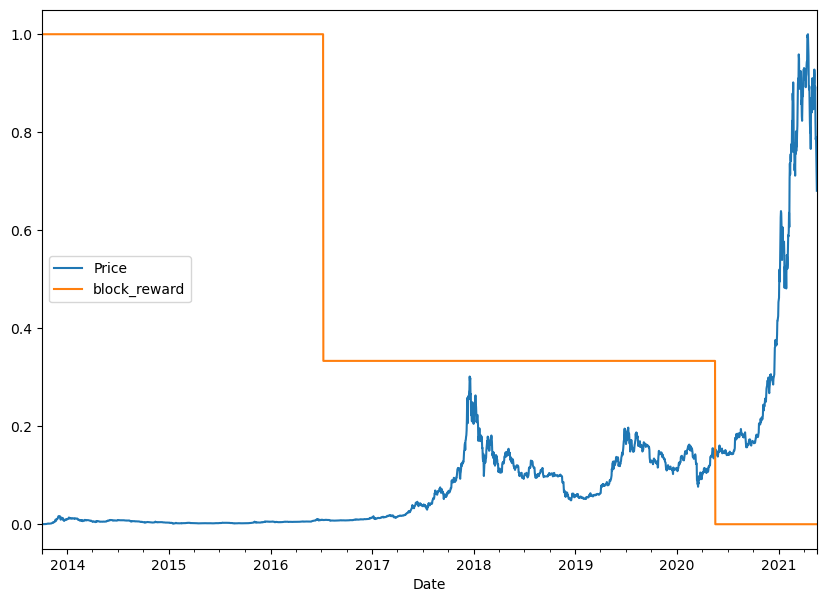

In [128]:
# Plot the block reward vs price over time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                                                       columns=bitcoin_prices_block.columns,
                                                                       index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

## Making a windowed dataset with pandas

Previously, we've turned our univariate time series into windowed dataset using the helper functions above.

However, since we've got multivariate data, these functions won't work.

Not to worry, we can use the pandas.DataFrame.shift() method to window our multivariate data.

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html

In [129]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [130]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


para los valores price+1 a price+7 el horizonte es price

In [131]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.25,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


What we've done is created a way to window our dataset directly from a pandas dataframe.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

In [133]:


# vamos a quitar lo que no tiene valores (los NaN)



# price será la etiqueta


# Create X (windows) and y (horizons) features
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [134]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [135]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

### Model 6: Dense (multivariate time series)

In [137]:


def build_model_6(horizon,name):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128,activation='relu'),
        tf.keras.layers.Dense(horizon)
    ],name=name)
    return model
    
    
model_6 = build_model_6(HORIZON,"model_6_dense_multivariate")    


# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/100
 1/18 [>.............................] - ETA: 7s - loss: 2952.7373INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 29ms/step - loss: 1524.6774 - val_loss: 1227.4307
Epoch 2/100
18/18 [==============================] - 0s 5ms/step - loss: 312.8433 - val_loss: 1651.2336
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 298.3595INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 28ms/step - loss: 218.9932 - val_loss: 1049.0228
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 210.0824INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 187.6530 - val_loss: 1006.8889
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 183.9075INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 26ms/step - loss: 175.9696 - val_loss: 978.2465
Epoch 6/100
18/18 [==============================] - 0s 3ms/step - loss: 171.5327 - val_loss: 988.4682
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 171.6916INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 166.6340 - val_loss: 924.1897
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 120.9022INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 26ms/step - loss: 163.2576 - val_loss: 905.7758
Epoch 9/100
18/18 [==============================] - 0s 3ms/step - loss: 159.4155 - val_loss: 923.5968
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 123.5954INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 26ms/step - loss: 157.5459 - val_loss: 899.5414
Epoch 11/100
18/18 [==============================] - 0s 3ms/step - loss: 159.9817 - val_loss: 951.6339
Epoch 12/100
 1/18 [>.............................] - ETA: 0s - loss: 173.6664INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 150.5420 - val_loss: 831.9655
Epoch 13/100
 1/18 [>.............................] - ETA: 0s - loss: 186.2802INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 26ms/step - loss: 146.6423 - val_loss: 828.4403
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 150.6771INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 146.3798 - val_loss: 803.9125
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 166.9917INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 143.9292 - val_loss: 786.8995
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 128.0047INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 139.3376 - val_loss: 771.0641
Epoch 17/100
 1/18 [>.............................] - ETA: 0s - loss: 212.4901INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 27ms/step - loss: 137.6528 - val_loss: 761.1500
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 122.4754INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 22ms/step - loss: 136.5917 - val_loss: 759.6611
Epoch 19/100
 1/18 [>.............................] - ETA: 0s - loss: 159.2755INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 136.9578 - val_loss: 737.0980
Epoch 20/100
18/18 [==============================] - 0s 3ms/step - loss: 146.3174 - val_loss: 944.2704
Epoch 21/100
18/18 [==============================] - 0s 2ms/step - loss: 148.5249 - val_loss: 816.6666
Epoch 22/100
 1/18 [>.............................] - ETA: 0s - loss: 145.4591INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 137.5255 - val_loss: 723.8448
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 175.9578INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 41ms/step - loss: 133.4268 - val_loss: 711.6850
Epoch 24/100
18/18 [==============================] - 0s 4ms/step - loss: 132.3896 - val_loss: 792.3271
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 153.8207INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 34ms/step - loss: 138.9625 - val_loss: 695.9587
Epoch 26/100
18/18 [==============================] - 0s 3ms/step - loss: 130.9828 - val_loss: 725.3970
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 131.4817INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 126.3712 - val_loss: 681.9527
Epoch 28/100
 1/18 [>.............................] - ETA: 0s - loss: 157.9950INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 27ms/step - loss: 124.2420 - val_loss: 674.3984
Epoch 29/100
 1/18 [>.............................] - ETA: 0s - loss: 174.3005INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 27ms/step - loss: 124.0979 - val_loss: 672.3326
Epoch 30/100
 1/18 [>.............................] - ETA: 0s - loss: 87.9988INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 124.3253 - val_loss: 660.5511
Epoch 31/100
 1/18 [>.............................] - ETA: 0s - loss: 136.3183INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 122.3110 - val_loss: 654.5392
Epoch 32/100
 1/18 [>.............................] - ETA: 0s - loss: 110.7184INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 126.1442 - val_loss: 649.9575
Epoch 33/100
 1/18 [>.............................] - ETA: 0s - loss: 110.2261INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 26ms/step - loss: 120.5905 - val_loss: 645.7056
Epoch 34/100
18/18 [==============================] - 0s 2ms/step - loss: 125.1034 - val_loss: 687.4464
Epoch 35/100
18/18 [==============================] - 0s 2ms/step - loss: 128.8898 - val_loss: 660.7290
Epoch 36/100
18/18 [==============================] - 0s 2ms/step - loss: 122.3476 - val_loss: 648.2538
Epoch 37/100
18/18 [==============================] - 0s 2ms/step - loss: 123.8251 - val_loss: 666.9791
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 120.3402INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 118.4751 - val_loss: 629.9024
Epoch 39/100
18/18 [==============================] - 0s 2ms/step - loss: 121.6059 - val_loss: 674.7604
Epoch 40/100
 1/18 [>.............................] - ETA: 0s - loss: 102.9360INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 120.8600 - val_loss: 619.4395
Epoch 41/100
18/18 [==============================] - 0s 3ms/step - loss: 115.5560 - val_loss: 626.9992
Epoch 42/100
 1/18 [>.............................] - ETA: 0s - loss: 98.3765INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 117.9478 - val_loss: 614.5446
Epoch 43/100
18/18 [==============================] - 0s 2ms/step - loss: 113.8737 - val_loss: 618.8337
Epoch 44/100
 1/18 [>.............................] - ETA: 0s - loss: 89.4212INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 117.7067 - val_loss: 612.4554
Epoch 45/100
18/18 [==============================] - 0s 2ms/step - loss: 113.5795 - val_loss: 630.5093
Epoch 46/100
 1/18 [>.............................] - ETA: 0s - loss: 117.6780INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 114.4447 - val_loss: 605.9822
Epoch 47/100
18/18 [==============================] - 0s 2ms/step - loss: 113.7605 - val_loss: 645.9155
Epoch 48/100
 1/18 [>.............................] - ETA: 0s - loss: 135.3440INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 115.3866 - val_loss: 598.8464
Epoch 49/100
18/18 [==============================] - 0s 2ms/step - loss: 119.7519 - val_loss: 673.7196
Epoch 50/100
 1/18 [>.............................] - ETA: 0s - loss: 148.4007INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 115.3467 - val_loss: 596.2892
Epoch 51/100
18/18 [==============================] - 0s 2ms/step - loss: 113.4283 - val_loss: 601.5012
Epoch 52/100
18/18 [==============================] - 0s 2ms/step - loss: 115.7531 - val_loss: 630.1544
Epoch 53/100
18/18 [==============================] - 0s 2ms/step - loss: 114.7355 - val_loss: 638.9988
Epoch 54/100
18/18 [==============================] - 0s 2ms/step - loss: 112.0144 - val_loss: 607.6483
Epoch 55/100
 1/18 [>.............................] - ETA: 0s - loss: 154.1101INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 110.5308 - val_loss: 588.5137
Epoch 56/100
18/18 [==============================] - 0s 2ms/step - loss: 114.1294 - val_loss: 600.7812
Epoch 57/100
18/18 [==============================] - 0s 2ms/step - loss: 110.4559 - val_loss: 605.9295
Epoch 58/100
18/18 [==============================] - 0s 2ms/step - loss: 112.8198 - val_loss: 596.2585
Epoch 59/100
18/18 [==============================] - 0s 3ms/step - loss: 110.2022 - val_loss: 591.1107
Epoch 60/100
18/18 [==============================] - 0s 2ms/step - loss: 112.2882 - val_loss: 608.3466
Epoch 61/100
 1/18 [>.............................] - ETA: 0s - loss: 93.7934INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 111.9930 - val_loss: 581.9383
Epoch 62/100
18/18 [==============================] - 0s 2ms/step - loss: 112.3404 - val_loss: 607.6012
Epoch 63/100
 1/18 [>.............................] - ETA: 0s - loss: 123.0573INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 116.9757 - val_loss: 578.9385
Epoch 64/100
18/18 [==============================] - 0s 2ms/step - loss: 113.4831 - val_loss: 579.3309
Epoch 65/100
18/18 [==============================] - 0s 2ms/step - loss: 108.6750 - val_loss: 635.5574
Epoch 66/100
18/18 [==============================] - 0s 2ms/step - loss: 112.5177 - val_loss: 619.4232
Epoch 67/100
18/18 [==============================] - 0s 2ms/step - loss: 121.4706 - val_loss: 697.2391
Epoch 68/100
18/18 [==============================] - 0s 2ms/step - loss: 126.3812 - val_loss: 633.2131
Epoch 69/100
 1/18 [>.............................] - ETA: 0s - loss: 122.1800INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 43ms/step - loss: 116.3911 - val_loss: 576.5401
Epoch 70/100
18/18 [==============================] - 0s 3ms/step - loss: 109.1181 - val_loss: 587.5417
Epoch 71/100
18/18 [==============================] - 0s 2ms/step - loss: 109.3600 - val_loss: 579.1257
Epoch 72/100
18/18 [==============================] - 0s 2ms/step - loss: 108.2270 - val_loss: 611.7188
Epoch 73/100
18/18 [==============================] - 0s 3ms/step - loss: 109.8227 - val_loss: 588.0494
Epoch 74/100
18/18 [==============================] - 0s 3ms/step - loss: 110.4644 - val_loss: 638.2268
Epoch 75/100
18/18 [==============================] - 0s 2ms/step - loss: 111.1425 - val_loss: 592.0637
Epoch 76/100
 1/18 [>.............................] - ETA: 0s - loss: 136.9240INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 28ms/step - loss: 108.1082 - val_loss: 569.3535
Epoch 77/100
18/18 [==============================] - 0s 3ms/step - loss: 106.8821 - val_loss: 579.5345
Epoch 78/100
18/18 [==============================] - 0s 2ms/step - loss: 108.3768 - val_loss: 639.3200
Epoch 79/100
 1/18 [>.............................] - ETA: 0s - loss: 106.2811INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 110.2267 - val_loss: 569.0464
Epoch 80/100
 1/18 [>.............................] - ETA: 0s - loss: 112.0782INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 106.5542 - val_loss: 567.2991
Epoch 81/100
18/18 [==============================] - 0s 2ms/step - loss: 111.0223 - val_loss: 600.0283
Epoch 82/100
18/18 [==============================] - 0s 2ms/step - loss: 109.2815 - val_loss: 585.1177
Epoch 83/100
 1/18 [>.............................] - ETA: 0s - loss: 137.5521INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 31ms/step - loss: 107.9334 - val_loss: 565.7302
Epoch 84/100
18/18 [==============================] - 0s 3ms/step - loss: 107.0253 - val_loss: 580.6442
Epoch 85/100
18/18 [==============================] - 0s 3ms/step - loss: 109.6492 - val_loss: 602.4525
Epoch 86/100
18/18 [==============================] - 0s 3ms/step - loss: 111.3265 - val_loss: 583.5314
Epoch 87/100
18/18 [==============================] - 0s 3ms/step - loss: 109.1278 - val_loss: 584.1075
Epoch 88/100
18/18 [==============================] - 0s 3ms/step - loss: 107.5808 - val_loss: 585.1985
Epoch 89/100
18/18 [==============================] - 0s 3ms/step - loss: 106.4854 - val_loss: 565.8332
Epoch 90/100
18/18 [==============================] - 0s 3ms/step - loss: 106.3066 - val_loss: 567.7229
Epoch 91/100
18/18 [==============================] - 0s 3ms/step - loss: 107.3190 - val_loss: 611.1632
Epoch 92/100
18/18 [==============================] - 0s 3ms/step - loss: 10

In [138]:
# Evaluate multivariate model
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 953us/step - loss: 639.9278


639.9277954101562

In [139]:
# Load in and evaluate best performing model
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 995us/step - loss: 565.7302


565.730224609375

In [140]:
# Make predictions with multivariate model
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8887.779, 8820.698, 9011.113, 8780.941, 8801.286, 8723.217,
       8699.792, 8548.725, 8479.107, 8531.815], dtype=float32)>

In [141]:
# Evaluate predictions to get eval metrics
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 565.7303,
 'mse': 1161352.1,
 'rmse': 1077.6605,
 'mape': 2.534177,
 'mase': 0.9938314}

In [142]:
model_1_results

{'mae': 567.71954,
 'mse': 1163274.8,
 'rmse': 1078.5521,
 'mape': 2.557755,
 'mase': 0.997326}

For a challenge on different ways to potentially improve the multivariate time series model, see the reference here: https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#model-6-dense-multivariate-time-series

## Model 7: N-BEATS algorithm

Let's now try build the biggest baddest (though maybe not the baddest, as in, it perform really well...) time series forecasting model we've built so far.

More specifically, we're going to be replicating the algorithm in Figure 1 from the following paper: https://arxiv.org/pdf/1905.10437.pdf

Why?

* This will allow us to practice replicating a paper with TensorFlow code
* We will see how to use TensorFlow layer subclassing (to make our own custom layers)
* Get experience using the Functional API to create a custom architecture 
* Potentially get state of the art results on our problem 

### Building and testing the N-BEATS block layer

Because the N-BEATS block layer doesn't exist in TensorFlow, we've got to create it.

To create custom layers and models in TensorFlow we can use subclassing: https://www.tensorflow.org/guide/keras/custom_layers_and_models
